In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble, preprocessing, linear_model, svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import math

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Téléchargement des différents jeux de données nettoyés

# Jeu de donnée nettoyé avec outliers
data = pd.read_csv('data_NonRes.csv', sep=';')

# Jeu de données nettoyé sans outliers (TotalGHGEmissions et SiteEnergyUse)
data_of = pd.read_csv('data_of.csv', sep=';')

# Jeu de données pour évaluer l'intérêt de l'utilisation du ENERGYSTARScore pour la prédiction de GHGEmissions
data_ESS = pd.read_csv('data_NonRes_ESS.csv', sep=';')

In [3]:
data.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,log10PropertyGFAParking,PropertyGFABuilding(s),log10PropertyGFABuilding,ENERGYSTARScore,log10ENERGYSTARScore,sqrtENERGYSTARScore,prop_electricity,prop_steam,prop_naturalgas,SiteEnergyUse(kBtu),log10SiteEnergyUse,TotalGHGEmissions,log10GHGEmissions
0,Hotel,DOWNTOWN,1927,1.0,12.0,0,4.690196,88434,4.946619,65.0,1.812913,8.062258,0.527984,0.289767,0.182249,6981428.0,6.843944,249.43,2.396949
1,Hotel,DOWNTOWN,1996,1.0,11.0,15064,4.806614,88502,4.946953,51.0,1.707570,7.141428,0.467468,0.000000,0.532532,8354235.0,6.921907,263.51,2.420797
2,Hotel,DOWNTOWN,1969,1.0,41.0,0,4.690196,961990,5.983171,18.0,1.255273,4.242641,0.680440,0.268832,0.050728,73130656.0,7.864099,2061.48,3.314179
3,Hotel,DOWNTOWN,1926,1.0,10.0,0,4.690196,61320,4.787602,1.0,0.000000,1.000000,0.098090,0.830995,0.070915,28229320.0,7.450700,1936.34,3.286982
4,Hotel,DOWNTOWN,1980,1.0,18.0,12460,4.788593,107430,5.031126,67.0,1.826075,8.185353,0.409070,0.000000,0.590930,14829099.0,7.171115,507.70,2.705607


In [4]:
data.shape

(2483, 19)

In [5]:
# Code pour afficher toutes les colonnes et tout leur contenu
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 200
    display.max_rows = 100
    display.max_colwidth = 200
    display.width = None
set_pandas_display_options()

In [6]:
data.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,log10PropertyGFAParking,PropertyGFABuilding(s),log10PropertyGFABuilding,ENERGYSTARScore,log10ENERGYSTARScore,sqrtENERGYSTARScore,prop_electricity,prop_steam,prop_naturalgas,SiteEnergyUse(kBtu),log10SiteEnergyUse,TotalGHGEmissions,log10GHGEmissions
0,Hotel,DOWNTOWN,1927,1.0,12.0,0,4.690196,88434,4.946619,65.0,1.812913,8.062258,0.527984,0.289767,0.182249,6981428.0,6.843944,249.43,2.396949
1,Hotel,DOWNTOWN,1996,1.0,11.0,15064,4.806614,88502,4.946953,51.0,1.707570,7.141428,0.467468,0.000000,0.532532,8354235.0,6.921907,263.51,2.420797
2,Hotel,DOWNTOWN,1969,1.0,41.0,0,4.690196,961990,5.983171,18.0,1.255273,4.242641,0.680440,0.268832,0.050728,73130656.0,7.864099,2061.48,3.314179
3,Hotel,DOWNTOWN,1926,1.0,10.0,0,4.690196,61320,4.787602,1.0,0.000000,1.000000,0.098090,0.830995,0.070915,28229320.0,7.450700,1936.34,3.286982
4,Hotel,DOWNTOWN,1980,1.0,18.0,12460,4.788593,107430,5.031126,67.0,1.826075,8.185353,0.409070,0.000000,0.590930,14829099.0,7.171115,507.70,2.705607


# 1) Développement du modèle pour prédiction du SiteEnergyUse

### Choix des features pour la target "SiteEnergyUse"

In [7]:
# find the most correlated quantitative columns for SiteEnergyUse:
data_corr = abs(data[['SiteEnergyUse(kBtu)',
                      'PropertyGFABuilding(s)',
                     'NumberofBuildings',
                     'log10PropertyGFABuilding',
                     'NumberofFloors',
                     'PropertyGFAParking',
                     'prop_steam',
                     'log10PropertyGFAParking',
                     'YearBuilt',
                     'prop_naturalgas',
                     'prop_electricity']].corr()).sort_values(by='SiteEnergyUse(kBtu)',
                                         ascending=False)[['SiteEnergyUse(kBtu)']]
data_corr

,SiteEnergyUse(kBtu)
SiteEnergyUse(kBtu),1.000000
PropertyGFABuilding(s),0.870223
NumberofBuildings,0.703551
log10PropertyGFABuilding,0.497712
NumberofFloors,0.264218
PropertyGFAParking,0.192109
prop_steam,0.182606
log10PropertyGFAParking,0.178196
YearBuilt,0.065697
prop_naturalgas,0.063578


In [8]:
data.columns

Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'log10PropertyGFAParking',
       'PropertyGFABuilding(s)', 'log10PropertyGFABuilding', 'ENERGYSTARScore',
       'log10ENERGYSTARScore', 'sqrtENERGYSTARScore', 'prop_electricity',
       'prop_steam', 'prop_naturalgas', 'SiteEnergyUse(kBtu)',
       'log10SiteEnergyUse', 'TotalGHGEmissions', 'log10GHGEmissions'],
      dtype='object')

In [9]:
# Création d'une matrice contenant toutes les features quantitatives et catégorielles
# les features catégorielles seront ensuite encodées avec OneHotEncoder
# (Sans ENERGYSTARScore)
selfeat_X1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X1 = ['PrimaryPropertyType', 'Neighborhood']
X1 = data[selfeat_X1]

# Création d'une matrice avec features corrélées à plus de 0.1 et features catégorielles
# on retire les features corrélées entre elles à plus de 0.6
# (NumberofBuilding(s) corrélée à PropertyGFABuilding(s) à 0.73)
selfeat_X2 = ['PrimaryPropertyType', 'Neighborhood', 'NumberofFloors',
              'PropertyGFAParking', 'PropertyGFABuilding(s)', 'prop_steam']
selcatfeat_X2 = ['PrimaryPropertyType', 'Neighborhood']
X2 = data[selfeat_X2]

# Création d'une matrice avec features corrélées à plus de 0.4 et features catégorielles
selfeat_X3 = ['PrimaryPropertyType', 'Neighborhood', 'PropertyGFABuilding(s)']
selcatfeat_X3 = ['PrimaryPropertyType', 'Neighborhood']
X3 = data[selfeat_X3]

# Comme X1 sans 'Neighborhood' (moins corrélée à SiteEnergyUse que 'PrimaryPropertyType')
selfeat_X4 = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X4 = ['PrimaryPropertyType']
X4 = data[selfeat_X4]

# Comme X2 sans 'Neighborhood'
selfeat_X5 = ['PrimaryPropertyType', 'NumberofFloors',
              'PropertyGFAParking', 'PropertyGFABuilding(s)', 'prop_steam']
selcatfeat_X5 = ['PrimaryPropertyType']
X5 = data[selfeat_X5]

# Comme X3 sans 'Neighborhood'
selfeat_X6 = ['PrimaryPropertyType', 'PropertyGFABuilding(s)']
selcatfeat_X6 = ['PrimaryPropertyType']
X6 = data[selfeat_X6]

# Comme X1 sans variables catégorielles
selfeat_X7 = ['YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X7 = []
X7 = data[selfeat_X7]

# Comme X2 sans variables catégorielles
selfeat_X8 = ['NumberofFloors',
              'PropertyGFAParking', 'PropertyGFABuilding(s)', 'prop_steam']
selcatfeat_X8 = []
X8 = data[selfeat_X8]

# Comme X3 sans variables catégorielles
selfeat_X9 = ['PropertyGFABuilding(s)']
selcatfeat_X9 = []
X9 = data[selfeat_X9]

# Création de l'array 'target' : SiteEnergyUse
ye = data['SiteEnergyUse(kBtu)'].values

### Choix des features pour la target "log10SiteEnergyUse"

In [10]:
# find the most correlated quantitative columns for log10SiteEnergyUse:
data_corr = abs(data[['log10SiteEnergyUse',
                      'PropertyGFABuilding(s)',
                     'NumberofBuildings',
                     'log10PropertyGFABuilding',
                     'NumberofFloors',
                     'PropertyGFAParking',
                     'prop_steam',
                     'log10PropertyGFAParking',
                     'YearBuilt',
                     'prop_naturalgas',
                     'prop_electricity']].corr()).sort_values(by='log10SiteEnergyUse',
                                         ascending=False)[['log10SiteEnergyUse']]
data_corr

,log10SiteEnergyUse
log10SiteEnergyUse,1.000000
log10PropertyGFABuilding,0.775712
PropertyGFABuilding(s),0.487396
NumberofFloors,0.443528
log10PropertyGFAParking,0.442577
PropertyGFAParking,0.404405
YearBuilt,0.241249
prop_steam,0.190004
NumberofBuildings,0.146028
prop_naturalgas,0.068057


In [11]:
# Création d'une matrice contenant toutes les features quantitatives et catégorielles
# les features catégorielles seront ensuite encodées avec OneHotEncoder
# (Sans ENERGYSTARScore)
selfeat_X1_log = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X1 = ['PrimaryPropertyType', 'Neighborhood']
X1_log = data[selfeat_X1_log]

# Création d'une matrice avec features corrélées à plus de 0.1 et features catégorielles
# on retire les features corrélées entre elles à plus de 0.6
selfeat_X2_log = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_steam']
selcatfeat_X2 = ['PrimaryPropertyType', 'Neighborhood']
X2_log = data[selfeat_X2_log]

# Création d'une matrice avec features corrélées à plus de 0.4 et features catégorielles
selfeat_X3_log = ['PrimaryPropertyType', 'Neighborhood',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding']
selcatfeat_X3 = ['PrimaryPropertyType', 'Neighborhood']
X3_log = data[selfeat_X3_log]

# Comme X1 sans 'Neighborhood' (moins corrélée à SiteEnergyUse que 'PrimaryPropertyType')
selfeat_X4_log = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X4 = ['PrimaryPropertyType']
X4_log = data[selfeat_X4_log]

# Comme X2 sans 'Neighborhood'
selfeat_X5_log = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_steam']
selcatfeat_X5 = ['PrimaryPropertyType']
X5_log = data[selfeat_X5_log]

# Comme X3 sans 'Neighborhood'
selfeat_X6_log = ['PrimaryPropertyType',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding']
selcatfeat_X6 = ['PrimaryPropertyType']
X6_log = data[selfeat_X6_log]

# Création de l'array 'target' : SiteEnergyUse
ye = data['SiteEnergyUse(kBtu)'].values

In [12]:
# Définition de fonctions pour afficher les Stats de SiteEnergyUse:

def SiteEnergyUse(df):
    # impression des statistiques de SiteEnergyUse
    print("SiteEnergyUse")
    print("moy :",df['SiteEnergyUse(kBtu)'].mean())
    print("med :",df['SiteEnergyUse(kBtu)'].median())
    print("var :",df['SiteEnergyUse(kBtu)'].var())
    print("std :",df['SiteEnergyUse(kBtu)'].std())

def logSiteEnergyUse(df):
    # impression des statistiques de log10SiteEnergyUse
    print("log10SiteEnergyUse")
    print("moy :",np.log10(df['SiteEnergyUse(kBtu)']).mean())
    print("med :",np.log10(df['SiteEnergyUse(kBtu)']).median())
    print("var :",np.log10(df['SiteEnergyUse(kBtu)']).var())
    print("std :",np.log10(df['SiteEnergyUse(kBtu)']).std())

### Test des différents dataframes sur régression linéaire classique (+ cross-validation) et target "SiteEnergyUse"

In [13]:
# Définition de la fonction régression linéaire avec cross-validation
def LinReg_cv(Xx, selcatfeat, y, n_splits, n_repeats):
    
    """[summary]

    Args:
        Xx (pd.dataframe) : dataframe à tester contenant les différentes features
        selcatfeat (liste) : liste des features catégorielles contenues dans le dataframe Xx
        y (array) : array de la target
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validation
    """
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X = pd.get_dummies(Xx, columns = selcatfeat, drop_first=True)
    else:
        X = Xx
    
    cv = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats)

    lr = linear_model.LinearRegression()

    lr_scores = cross_validate(lr, X, y, cv = cv,
                               scoring = ('r2', 'neg_root_mean_squared_error'), # Utilisation de 2 metrics pour évaluation
                               return_train_score = True) # Affichage du train_score pour comparaison avec test_score
    
    # Enregistrement des résultats dans un dataframe pandas
    cv_results = pd.DataFrame(lr_scores)

    # Affichage des r2_scores moyens test et train
    print('moyenne r2 test =', cv_results['test_r2'].mean())
    print('écart-type r2 test =', cv_results['test_r2'].std())
    print('moyenne r2 train =', cv_results['train_r2'].mean())
    print('écart-type r2 train =', cv_results['train_r2'].std())

    print('------------------------------------')

    # Affichage des RMSE moyennes test et train
    print('moyenne RMSE test =', cv_results['test_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE test =', cv_results['test_neg_root_mean_squared_error'].std())
    print('moyenne RMSE train =', cv_results['train_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE train =', cv_results['train_neg_root_mean_squared_error'].std())

In [14]:
SiteEnergyUse(data)

SiteEnergyUse
moy : 7629566.688877992
med : 2394843.0
var : 639487291007129.8
std : 25288085.949852545


In [15]:
# Test des dataframe contenant les différentes features quantitatives et catégorielles
# de X1 à X9
LinReg_cv(Xx = X7, 
          selcatfeat = selcatfeat_X7, 
          y = ye, 
          n_splits = 5, 
          n_repeats = 100)

moyenne r2 test = 0.6248082342930157
écart-type r2 test = 0.15377633625387221
moyenne r2 train = 0.7674619633306566
écart-type r2 train = 0.08691873949740518
------------------------------------
moyenne RMSE test = -12051154.890863223
écart-type RMSE test = 3152639.720096972
moyenne RMSE train = -11638243.292834813
écart-type RMSE train = 670000.7981007905


*Conclusion*. Après avoir testé X1 à X9 :

- Meilleurs résultats avec toutes les features quantitatives

- La feature catégorielle "Neighborhood" n'est pas utile

- En revanche, l'utilisation de la feature catégorielle "PrimaryPropertyType" permet d'améliorer les résultats (r2 et RMSE)

-> On choisira le dataframe X4 pour la suite : toutes les features quantitatives + "PrimaryPropertyType"

### Test des différents dataframes sur régression linéaire classique et target "log10SiteEnergyUse"

In [16]:
# Définition d'une fonction permettant une régression linéaire sur "log10SiteEnergyUse"
# et retournant les résultats selon "log10SiteEnergyUse" et "SiteEnergyUse"
# A appeler après un train_test_split préalable
def LinReg_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # Application de la REGRESSION LINEAIRE classique
    lr = linear_model.LinearRegression()
    lr.fit(X_train_std, y_train_log)
    
    # Récupération du coefficient de détermination sur le jeu de données test
    r2_lr_test = r2_score(10**y_test_log, 10**(lr.predict(X_test_std)))
    r2_lr_log_test = r2_score(y_test_log, lr.predict(X_test_std))
    # Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
    RMSE_lr_test = math.sqrt(mean_squared_error(10**y_test_log, 10**(lr.predict(X_test_std))))
    RMSE_lr_log_test = math.sqrt(mean_squared_error(y_test_log, lr.predict(X_test_std)))
    
    # impression du coefficient de détermination
    print("REGRESSION LINEAIRE")
    print("r2_lr test :", r2_lr_test)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr test :", RMSE_lr_test)
    print("---------------------")
                         
        # impression du coefficient de détermination
    print("REGRESSION LINEAIRE LOG")
    print("r2_lr_log test :", r2_lr_log_test)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr_log test :", RMSE_lr_log_test)
    print("---------------------")
    
    
    # Récupération du coefficient de détermination sur le jeu de données train
    # après reconversion en non log et sur la target log
    r2_lr_train = r2_score(10**y_train_log, 10**(lr.predict(X_train_std)))
    r2_lr_log_train = r2_score(y_train_log, lr.predict(X_train_std))
    # Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
    # après reconversion en non log et sur la target log
    RMSE_lr_train = math.sqrt(mean_squared_error(10**y_train_log, 10**(lr.predict(X_train_std))))
    RMSE_lr_log_train = math.sqrt(mean_squared_error(y_train_log, lr.predict(X_train_std)))
    
    # impression du coefficient de détermination
    print("REGRESSION LINEAIRE")
    print("r2_lr train :", r2_lr_train)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr train :", RMSE_lr_train)
    print("---------------------")
                         
    # impression du coefficient de détermination
    print("REGRESSION LINEAIRE LOG")
    print("r2_lr_log train :", r2_lr_log_train)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr_log train :", RMSE_lr_log_train)
    print("---------------------")

In [17]:
# Définition d'une fonction permettant une régression linéaire sur "SiteEnergyUse"
# A appeler après un train_test_split préalable
def LinReg(selfeat, selcatfeat, X_train, X_test, y_train, y_test):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)
    
    # Application de la REGRESSION LINEAIRE classique
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    # Récupération du coefficient de détermination sur le jeu de données test
    r2_lr_test = r2_score(y_test, lr.predict(X_test))
    # Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
    RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
    # impression du coefficient de détermination
    print("REGRESSION LINEAIRE")
    print("r2_lr test :", r2_lr_test)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr test :", RMSE_lr_test)
    print('-----------------------')
    
    # Récupération du coefficient de détermination sur le jeu de données train
    r2_lr_train = r2_score(y_train, lr.predict(X_train))
    # Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données train
    RMSE_lr_train = math.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
    
    # impression du coefficient de détermination
    print("REGRESSION LINEAIRE")
    print("r2_lr train :", r2_lr_train)
    # impression de la Root Mean Squared Error (RMSE)
    print("RMSE_lr train :", RMSE_lr_train)
    print('-----------------------')

In [18]:
# Création d'un dataframe contenant toutes les features et sans les target
# Afin de comparer la régression linéaire sur "SiteEnergyUse" et "log10SiteEnergyUse"
# sur le même train_test_split
X = data[['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'PropertyGFAParking', 'log10PropertyGFABuilding',
              'PropertyGFABuilding(s)', 'prop_electricity', 'prop_steam', 'prop_naturalgas']]

In [19]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X, ye, test_size=0.30)

In [20]:
# Régression linéaire sur "log10SiteEnergyUse"
LinReg_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : -106882.42220812652
RMSE_lr test : 11515236713.593727
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log test : 0.7045107773128954
RMSE_lr_log test : 0.30954425127701707
---------------------
REGRESSION LINEAIRE
r2_lr train : 0.855893107929246
RMSE_lr train : 7413763.593072757
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log train : 0.7761753021326379
RMSE_lr_log train : 0.26825648987681977
---------------------


In [21]:
# Régression linéaire sur "SiteEnergyUse"
LinReg(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.9298076741500065
RMSE_lr test : 9331737.447874812
-----------------------
REGRESSION LINEAIRE
r2_lr train : 0.8027316697979348
RMSE_lr train : 8674112.322266188
-----------------------


Conclusion : Sélection du X5_log pour la suite des expériences sur la target "log10SiteEnergyUse"

### Test des dataframe X4 et X5_log sur d'autres algorithmes de Machine Learning

In [22]:
# Définition d'une fonction régression ridge avec optimisation 
# de l'hyperparamètre alphas via RidgeCV (GridSearch et Cross-validation)
def RidgeReg(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
             logspacemin, logspacemax, n_alphas, n_splits, n_repeats):
    
    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # REGRESSION RIDGE avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    alphas=np.logspace(logspacemin, logspacemax, n_alphas)
    
     # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    ridge_reg = linear_model.RidgeCV(alphas=alphas,
                                     cv=cv)

    # Application de la régression ridge au jeu de données normalisées
    ridge_reg.fit(X_train_std, y_train)

    # Affichage de la valeur optimal alpha
    ridge_optimal_alpha = ridge_reg.alpha_
    print("REGRESSION RIDGE avec validation croisée :")
    print('ridge optimal alpha :', ridge_optimal_alpha)

    # Application de la régression ridge optimale avec la valeur optimale de l'alpha
    ridge_opt = linear_model.Ridge(alpha=ridge_optimal_alpha)
    ridge_opt.fit(X_train_std, y_train)

    # Définition des prédictions sur jeu de test
    ridge_opt_preds = ridge_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("ridge r2_score test :", r2_score(y_test, ridge_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("ridge RMSE test :", math.sqrt(mean_squared_error(y_test, ridge_opt_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    ridge_opt_preds_train = ridge_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("ridge r2_score train :", r2_score(y_train, ridge_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("ridge RMSE train :", math.sqrt(mean_squared_error(y_train, ridge_opt_preds_train)))
    print("---------------------")

In [23]:
# Définition d'une fonction régression ridge (avec passage au log de la target) avec optimisation 
# de l'hyperparamètre alphas via RidgeCV (GridSearch et Cross-validation)
def RidgeReg_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
             logspacemin, logspacemax, n_alphas, n_splits, n_repeats):
    
    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # REGRESSION RIDGE avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    alphas=np.logspace(logspacemin, logspacemax, n_alphas)
    
     # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    ridge_reg = linear_model.RidgeCV(alphas=alphas,
                                     cv=cv)

    # Application de la régression ridge au jeu de données normalisées
    ridge_reg.fit(X_train_std, y_train_log)

    # Affichage de la valeur optimal alpha
    ridge_optimal_alpha = ridge_reg.alpha_
    print("REGRESSION RIDGE avec validation croisée :")
    print('ridge optimal alpha :', ridge_optimal_alpha)

    # Application de la régression ridge optimale avec la valeur optimale de l'alpha
    ridge_opt = linear_model.Ridge(alpha=ridge_optimal_alpha)
    ridge_opt.fit(X_train_std, y_train_log)

    # Définition des prédictions sur jeu de test
    ridge_opt_preds = ridge_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("ridge r2_score test :", r2_score(10**y_test_log, 10**ridge_opt_preds))
    print("ridge r2_score test log :", r2_score(y_test_log, ridge_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("ridge RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**ridge_opt_preds)))
    print("ridge RMSE test log :", math.sqrt(mean_squared_error(y_test_log, ridge_opt_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    ridge_opt_preds_train = ridge_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("ridge r2_score train :", r2_score(10**y_train_log, 10**ridge_opt_preds_train))
    print("ridge r2_score train log :", r2_score(y_train_log, ridge_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("ridge RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**ridge_opt_preds_train)))
    print("ridge RMSE train log :", math.sqrt(mean_squared_error(y_train_log, ridge_opt_preds_train)))
    print("---------------------")

In [24]:
# Définition d'une fonction lasso (avec passage au log de la target) avec optimisation 
# de l'hyperparamètre alphas via LassoCV (GridSearch et Cross-validation)
def Lasso_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
          logspacemin, logspacemax, n_alphas, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # LASSO avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    # différents compris entre logspacemin et logspacemax

    alphas = np.logspace(logspacemin, logspacemax, n_alphas)

    # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    lasso_reg = linear_model.LassoCV(alphas=alphas,
                                     cv=cv)

    # Application du lasso au jeu de données normalisées
    lasso_reg.fit(X_train_std, y_train_log)

    # Affichage de la valeur optimal alpha
    lasso_optimal_alpha = lasso_reg.alpha_
    print("LASSO avec validation croisée :")
    print('LASSO optimal alpha :', lasso_optimal_alpha)

    # Application du lasso optimal avec la valeur optimale de l'alpha
    lasso_opt = linear_model.Lasso(alpha=lasso_optimal_alpha)
    lasso_opt.fit(X_train_std, y_train_log)

    # Définition des prédictions sur jeu de test
    lasso_opt_preds = lasso_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("lasso r2_score test :", r2_score(10**y_test_log, 10**lasso_opt_preds))
    print("lasso r2_score test log :", r2_score(y_test_log, lasso_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("lasso RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**lasso_opt_preds)))
    print("lasso RMSE test log :", math.sqrt(mean_squared_error(y_test_log, lasso_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    lasso_opt_preds_train = lasso_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("lasso r2_score train :", r2_score(10**y_train_log, 10**lasso_opt_preds_train))
    print("lasso r2_score train log:", r2_score(y_train_log, lasso_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("lasso RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**lasso_opt_preds_train)))
    print("lasso RMSE train log :", math.sqrt(mean_squared_error(y_train_log, lasso_opt_preds_train)))
    print("---------------------")

In [25]:
# Définition d'une fonction lasso avec optimisation 
# de l'hyperparamètre alphas via LassoCV (GridSearch et Cross-validation)
def Lasso(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
          logspacemin, logspacemax, n_alphas, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test) 
    
    # LASSO avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    # différents compris entre logspacemin et logspacemax

    alphas = np.logspace(logspacemin, logspacemax, n_alphas)

    # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    lasso_reg = linear_model.LassoCV(alphas=alphas,
                                     cv=cv)

    # Application du lasso au jeu de données normalisées
    lasso_reg.fit(X_train_std, y_train)

    # Affichage de la valeur optimal alpha
    lasso_optimal_alpha = lasso_reg.alpha_
    print("LASSO avec validation croisée :")
    print('LASSO optimal alpha :', lasso_optimal_alpha)

    # Application du lasso optimal avec la valeur optimale de l'alpha
    lasso_opt = linear_model.Lasso(alpha=lasso_optimal_alpha)
    lasso_opt.fit(X_train_std, y_train)

    # Définition des prédictions sur jeu de test
    lasso_opt_preds = lasso_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("lasso r2_score test :", r2_score(y_test, lasso_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("lasso RMSE test :", math.sqrt(mean_squared_error(y_test, lasso_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    lasso_opt_preds_train = lasso_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("lasso r2_score train :", r2_score(y_train, lasso_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("lasso RMSE train :", math.sqrt(mean_squared_error(y_train, lasso_opt_preds_train)))
    print("---------------------")

In [26]:
# Définition d'une fonction ElasticNet (via passage au log de la target) avec optimisation 
# de l'hyperparamètre alphas via ElasticNetCV (GridSearch et Cross-validation)
def ElasticNet_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
               logspacemin, logspacemax, n_alphas, l1_ratio, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        l1_ratio : ratio de correction via la norme l1 par rapport aux normes l1 + l2
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test) 
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # ELASTIC NET avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    # différents compris entre logspacemin et logspacemax
    # et différents l1_ratio
    
    alphas = np.logspace(logspacemin, logspacemax, n_alphas)
    
    # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)

    elastic_net = linear_model.ElasticNetCV(l1_ratio=l1_ratio,
                                            alphas = alphas,
                                            cv=cv)

    # Application de l'elastic net au jeu de données normalisées
    elastic_net.fit(X_train_std, y_train_log)

    # Affichage de la valeur optimale alpha
    elastic_net_optimal_alpha = elastic_net.alpha_
    print("ELASTIC NET avec validation croisée :")
    print("elastic_net optimal alpha :", elastic_net_optimal_alpha)

    # Affichage de la valeur optimale du ratio l1/l2
    elastic_net_optimal_l1_ratio = elastic_net.l1_ratio_
    print("elastic_net optimal l1_ratio :", elastic_net_optimal_l1_ratio)

    # Application de l'elastic net optimal avec les valeurs optimales de l'alpha et du l1_ratio
    elastic_net_opt = linear_model.ElasticNet(alpha = elastic_net_optimal_alpha,
                                         l1_ratio = elastic_net_optimal_l1_ratio)

    elastic_net_opt.fit(X_train_std, y_train_log)

    # Définition des prédictions sur jeu de test
    elastic_net_opt_preds = elastic_net_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("elastic net r2_score test :", r2_score(10**y_test_log, 10**elastic_net_opt_preds))
    print("elastic net r2_score test log:", r2_score(y_test_log, elastic_net_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("elastic net RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**elastic_net_opt_preds)))
    print("elastic net RMSE test log :", math.sqrt(mean_squared_error(y_test_log, elastic_net_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    elastic_net_opt_preds_train = elastic_net_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("elastic net r2_score train :", r2_score(10**y_train_log, 10**elastic_net_opt_preds_train))
    print("elastic net r2_score train log :", r2_score(y_train_log, elastic_net_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("elastic net RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**elastic_net_opt_preds_train)))
    print("elastic net RMSE train log :", math.sqrt(mean_squared_error(y_train_log, elastic_net_opt_preds_train)))
    print("---------------------")

In [27]:
# Définition d'une fonction ElasticNet avec optimisation 
# de l'hyperparamètre alphas via ElasticNetCV (GridSearch et Cross-validation)
def ElasticNet(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
               logspacemin, logspacemax, n_alphas, l1_ratio, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_alphas (int) : définition de l'espace de recherche du meilleur alpha
        l1_ratio : ratio de correction via la norme l1 par rapport aux normes l1 + l2
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test) 
    
    # ELASTIC NET avec validation croisée
    # On test n_alphas coefficients alphas (coeff de régularisation = hyperparamètre) 
    # différents compris entre logspacemin et logspacemax
    # et différents l1_ratio
    
    alphas = np.logspace(logspacemin, logspacemax, n_alphas)
    
    # Définition de la méthode de validation croisée
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)

    elastic_net = linear_model.ElasticNetCV(l1_ratio=l1_ratio,
                                            alphas = alphas,
                                            cv=cv)

    # Application de l'elastic net au jeu de données normalisées
    elastic_net.fit(X_train_std, y_train)

    # Affichage de la valeur optimale alpha
    elastic_net_optimal_alpha = elastic_net.alpha_
    print("ELASTIC NET avec validation croisée :")
    print("elastic_net optimal alpha :", elastic_net_optimal_alpha)

    # Affichage de la valeur optimale du ratio l1/l2
    elastic_net_optimal_l1_ratio = elastic_net.l1_ratio_
    print("elastic_net optimal l1_ratio :", elastic_net_optimal_l1_ratio)

    # Application de l'elastic net optimal avec les valeurs optimales de l'alpha et du l1_ratio
    elastic_net_opt = linear_model.ElasticNet(alpha = elastic_net_optimal_alpha,
                                         l1_ratio = elastic_net_optimal_l1_ratio)

    elastic_net_opt.fit(X_train_std, y_train)

    # Définition des prédictions sur jeu de test
    elastic_net_opt_preds = elastic_net_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("elastic net r2_score test :", r2_score(y_test, elastic_net_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("elastic net RMSE test :", math.sqrt(mean_squared_error(y_test, elastic_net_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    elastic_net_opt_preds_train = elastic_net_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("elastic net r2_score train :", r2_score(y_train, elastic_net_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("elastic net RMSE train :", math.sqrt(mean_squared_error(y_train, elastic_net_opt_preds_train)))
    print("---------------------")

In [28]:
# Définition d'une fonction LinearSVR avec optimisation 
# de l'hyperparamètre C via GridSearchCV (GridSearch et Cross-validation)
def LinearSVR(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
              logspacemin, logspacemax, n_C, n_iter, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)  
    
    # Construction d'un LinearSVR : avec validation croisée
    # du paramètre C (coeff de régularisation) sur jeu d'entrainement

    linear_svr = svm.LinearSVR()
    
    # Définition de la méthode de validation croisée
    param_grid = {'C' : np.logspace(logspacemin, logspacemax, n_C),
                  'max_iter' : n_iter}
    
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    linear_svr = GridSearchCV(estimator=linear_svr,
                              param_grid = param_grid,
                              cv = cv)

    # Application du LinearSVR au jeu de données normalisées
    linear_svr.fit(X_train_std, y_train)

    # Affichage des meilleurs paramètres
    linearSVR_best_C = list(linear_svr.best_params_.values())[0]
    print("LINEAR_SVR avec validation croisée :")
    print("linearSVR_best_C :", linearSVR_best_C)
    linearSVR_best_max_iter = list(linear_svr.best_params_.values())[1]
    print("linearSVR_best_max_iter :", linearSVR_best_max_iter)

    # Application du LinearSVR optimal avec les valeurs optimales de C et max_iter
    linear_svr_opt = svm.LinearSVR(C = linearSVR_best_C, 
                                   max_iter = linearSVR_best_max_iter)

    linear_svr_opt.fit(X_train_std, y_train)

    # Définition des prédictions sur jeu de test
    linear_svr_opt_preds = linear_svr_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("Linear_SVR r2_score test :", r2_score(y_test, linear_svr_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("Linear_SVR RMSE test :", math.sqrt(mean_squared_error(y_test, linear_svr_opt_preds)))
    print("---------------------")  
    
    # Définition des prédictions sur jeu de train
    linear_svr_opt_preds_train = linear_svr_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("Linear_SVR r2_score train :", r2_score(y_train, linear_svr_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("Linear_SVR RMSE train :", math.sqrt(mean_squared_error(y_train, linear_svr_opt_preds_train)))
    print("---------------------")

In [29]:
# Définition d'une fonction LinearSVR (via passage au log de la target) avec optimisation 
# de l'hyperparamètre C via GridSearchCV (GridSearch et Cross-validation)
def LinearSVR_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
              logspacemin, logspacemax, n_C, n_iter, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # Construction d'un LinearSVR : avec validation croisée
    # du paramètre C (coeff de régularisation) sur jeu d'entrainement

    linear_svr = svm.LinearSVR()
    
    # Définition de la méthode de validation croisée
    param_grid = {'C' : np.logspace(logspacemin, logspacemax, n_C),
                  'max_iter' : n_iter}
    
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    linear_svr = GridSearchCV(estimator=linear_svr,
                              param_grid = param_grid,
                              cv = cv)

    # Application du LinearSVR au jeu de données normalisées
    linear_svr.fit(X_train_std, y_train_log)

    # Affichage des meilleurs paramètres
    linearSVR_best_C = list(linear_svr.best_params_.values())[0]
    print("LINEAR_SVR avec validation croisée :")
    print("linearSVR_best_C :", linearSVR_best_C)
    linearSVR_best_max_iter = list(linear_svr.best_params_.values())[1]
    print("linearSVR_best_max_iter :", linearSVR_best_max_iter)

    # Application du LinearSVR optimal avec les valeurs optimales de C et max_iter
    linear_svr_opt = svm.LinearSVR(C = linearSVR_best_C, 
                                   max_iter = linearSVR_best_max_iter)

    linear_svr_opt.fit(X_train_std, y_train_log)

    # Définition des prédictions sur jeu de test
    linear_svr_opt_preds = linear_svr_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("Linear_SVR r2_score test :", r2_score(10**y_test_log, 10**linear_svr_opt_preds))
    print("Linear_SVR r2_score test log :", r2_score(y_test_log, linear_svr_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("Linear_SVR RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**linear_svr_opt_preds)))
    print("Linear_SVR RMSE test log :", math.sqrt(mean_squared_error(y_test_log, linear_svr_opt_preds)))
    print("---------------------")  
    
    # Définition des prédictions sur jeu de train
    linear_svr_opt_preds_train = linear_svr_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("Linear_SVR r2_score train :", r2_score(10**y_train_log, 10**linear_svr_opt_preds_train))
    print("Linear_SVR r2_score train log :", r2_score(y_train_log, linear_svr_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("Linear_SVR RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**linear_svr_opt_preds_train)))
    print("Linear_SVR RMSE train log :", math.sqrt(mean_squared_error(y_train_log, linear_svr_opt_preds_train)))
    print("---------------------")

In [30]:
# Définition d'une fonction SVR avec optimisation 
# de l'hyperparamètre C via GridSearchCV (GridSearch et Cross-validation)
def SVR(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
        logspacemin, logspacemax, n_C, n_iter, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_iter : nombre maximum d'itérations
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
        
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # construction d'un SVR : avec validation croisée
    # du paramètre C (coeff de régularisation) sur jeu d'entrainement
    
    param_grid = {'C' : np.logspace(logspacemin, logspacemax, n_C),
                  'max_iter' : n_iter}

    svr = svm.SVR()
    
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    gs_svr = GridSearchCV(estimator=svr,
                          param_grid=param_grid,
                          cv=cv)

    # Application du SVR au jeu de données normalisées 
    gs_svr.fit(X_train_std, y_train)

    # Affichage des meilleurs paramètres
    print("SVR avec validation croisée :")
    print("best_params :", gs_svr.best_params_)
    SVR_best_C = list(gs_svr.best_params_.values())[0]
    SVR_best_max_iter = list(gs_svr.best_params_.values())[1]

    # Application du LinearSVR optimal avec les valeurs optimales de C et max_iter
    svr_opt = svm.SVR(C = SVR_best_C,
                      max_iter = SVR_best_max_iter)

    svr_opt.fit(X_train_std, y_train)

    # Définition des prédictions sur jeu de test
    svr_opt_preds = svr_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("SVR r2_score test :", r2_score(y_test, svr_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("SVR RMSE test :", math.sqrt(mean_squared_error(y_test, svr_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    svr_opt_preds_train = svr_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("SVR r2_score train :", r2_score(y_train, svr_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("SVR RMSE train :", math.sqrt(mean_squared_error(y_train, svr_opt_preds_train)))
    print("---------------------") 

In [31]:
# Définition d'une fonction SVR (via passage au log de la target) avec optimisation 
# de l'hyperparamètre C via GridSearchCV (GridSearch et Cross-validation)
def SVR_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test, 
        logspacemin, logspacemax, n_C, n_iter, n_splits, n_repeats):

    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_iter : nombre maximum d'itérations
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
        
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    # Standardisation des données sur le jeu de données d'entrainement
    std_scale = preprocessing.StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # construction d'un SVR : avec validation croisée
    # du paramètre C (coeff de régularisation) sur jeu d'entrainement
    
    param_grid = {'C' : np.logspace(logspacemin, logspacemax, n_C),
                  'max_iter' : n_iter}

    svr = svm.SVR()
    
    cv = RepeatedKFold(n_splits=n_splits, 
                       n_repeats=n_repeats, 
                       random_state=1)
    
    gs_svr = GridSearchCV(estimator=svr,
                          param_grid=param_grid,
                          cv=cv)

    # Application du SVR au jeu de données normalisées 
    gs_svr.fit(X_train_std, y_train_log)

    # Affichage des meilleurs paramètres
    print("SVR avec validation croisée :")
    print("best_params :", gs_svr.best_params_)
    SVR_best_C = list(gs_svr.best_params_.values())[0]
    SVR_best_max_iter = list(gs_svr.best_params_.values())[1]

    # Application du LinearSVR optimal avec les valeurs optimales de C et max_iter
    svr_opt = svm.SVR(C = SVR_best_C,
                      max_iter = SVR_best_max_iter)

    svr_opt.fit(X_train_std, y_train_log)

    # Définition des prédictions sur jeu de test
    svr_opt_preds = svr_opt.predict(X_test_std)

    # impression du coefficient de détermination
    print("SVR r2_score test :", r2_score(10**y_test_log, 10**svr_opt_preds))
    print("SVR r2_score test log :", r2_score(y_test_log, svr_opt_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("SVR RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**svr_opt_preds)))
    print("SVR RMSE test log :", math.sqrt(mean_squared_error(y_test_log, svr_opt_preds)))
    print("---------------------")

    # Définition des prédictions sur jeu de train
    svr_opt_preds_train = svr_opt.predict(X_train_std)

    # impression du coefficient de détermination
    print("SVR r2_score train :", r2_score(10**y_train_log, 10**svr_opt_preds_train))
    print("SVR r2_score train log :", r2_score(y_train_log, svr_opt_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("SVR RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**svr_opt_preds_train)))
    print("SVR RMSE train log :", math.sqrt(mean_squared_error(y_train_log, svr_opt_preds_train)))
    print("---------------------") 

In [32]:
# Définition d'une fonction RandomForestRegressor avec paramètres par défaut
def RandomForest(selfeat, selcatfeat, X_train, X_test, y_train, y_test):
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    rfr = RandomForestRegressor()

    rfr.fit(X_train, y_train)

    # Définition des prédictions sur jeu de test
    rfr_preds = rfr.predict(X_test)

    # impression du coefficient de détermination
    print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    rfr_preds_train = rfr.predict(X_train)

    # impression du coefficient de détermination
    print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
    print("---------------------")

In [33]:
# Définition d'une fonction RandomForestRegressor (via passage au log de la target) 
# avec paramètres par défaut
def RandomForest_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test):
    
    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
        X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    rfr = RandomForestRegressor()

    rfr.fit(X_train, y_train_log)

    # Définition des prédictions sur jeu de test
    rfr_preds = rfr.predict(X_test)

    # impression du coefficient de détermination
    print("RandomForestRegressor_r2_score test :", r2_score(10**y_test_log, 10**rfr_preds))
    print("RandomForestRegressor_r2_score test log :", r2_score(y_test_log, rfr_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**rfr_preds)))
    print("RandomForestRegressor_RMSE test log :", math.sqrt(mean_squared_error(y_test_log, rfr_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    rfr_preds_train = rfr.predict(X_train)

    # impression du coefficient de détermination
    print("RandomForestRegressor_r2_score train :", r2_score(10**y_train_log, 10**rfr_preds_train))
    print("RandomForestRegressor_r2_score train log :", r2_score(y_train_log, rfr_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**rfr_preds_train)))
    print("RandomForestRegressor_RMSE train log :", math.sqrt(mean_squared_error(y_train_log, rfr_preds_train)))
    print("---------------------")

In [34]:
# Définition d'une fonction GradientBoostingRegressor avec paramètres par défaut
def GradientBoosting(selfeat, selcatfeat, X_train, X_test, y_train, y_test):

    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    gbr = ensemble.GradientBoostingRegressor()

    gbr.fit(X_train, y_train)

    # Définition des prédictions sur jeu de test
    gbr_preds = gbr.predict(X_test)

    # impression du coefficient de détermination
    print("GradientBoostingRegressor_r2_score test :", r2_score(y_test, gbr_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("GradientBoostingRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, gbr_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    gbr_preds_train = gbr.predict(X_train)

    # impression du coefficient de détermination
    print("GradientBoostingRegressor_r2_score train :", r2_score(y_train, gbr_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("GradientBoostingRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, gbr_preds_train)))
    print("---------------------")

In [35]:
# Définition d'une fonction GradientBoostingRegressor (via passage au log de la target) 
# avec paramètres par défaut
def GradientBoosting_log(selfeat, selcatfeat, X_train, X_test, y_train, y_test):

    # Sélection des features
    X_train = X_train[selfeat]
    X_test = X_test[selfeat]
    
    # Passage au log de la target
    y_train_log = np.log10(y_train)
    y_test_log = np.log10(y_test)
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    X_train = pd.get_dummies(X_train, columns = selcatfeat, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat, drop_first=True)

    gbr = ensemble.GradientBoostingRegressor()

    gbr.fit(X_train, y_train_log)

    # Définition des prédictions sur jeu de test
    gbr_preds = gbr.predict(X_test)

    # impression du coefficient de détermination
    print("GradientBoostingRegressor_r2_score test :", r2_score(10**y_test_log, 10**gbr_preds))
    print("GradientBoostingRegressor_r2_score test log :", r2_score(y_test_log, gbr_preds))
    # impression de la Root Mean Squared Error (RMSE)
    print("GradientBoostingRegressor_RMSE test :", math.sqrt(mean_squared_error(10**y_test_log, 10**gbr_preds)))
    print("GradientBoostingRegressor_RMSE test log :", math.sqrt(mean_squared_error(y_test_log, gbr_preds)))
    print("---------------------")
    
    # Définition des prédictions sur jeu de train
    gbr_preds_train = gbr.predict(X_train)

    # impression du coefficient de détermination
    print("GradientBoostingRegressor_r2_score train :", r2_score(10**y_train_log, 10**gbr_preds_train))
    print("GradientBoostingRegressor_r2_score train log :", r2_score(y_train_log, gbr_preds_train))
    # impression de la Root Mean Squared Error (RMSE)
    print("GradientBoostingRegressor_RMSE train :", math.sqrt(mean_squared_error(10**y_train_log, 10**gbr_preds_train)))
    print("GradientBoostingRegressor_RMSE train log :", math.sqrt(mean_squared_error(y_train_log, gbr_preds_train)))
    print("---------------------")

In [36]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X, ye, test_size=0.30)

In [106]:
# Régression linéaire sur "SiteEnergyUse"
LinReg(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.6802287846756114
RMSE_lr test : 7930368.721663584
-----------------------
REGRESSION LINEAIRE
r2_lr train : 0.9071288289416336
RMSE_lr train : 8767047.342245005
-----------------------


In [107]:
# Régression linéaire sur "log10SiteEnergyUse"
LinReg_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.7993735942292203
RMSE_lr test : 6281563.334032601
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log test : 0.7278257462180436
RMSE_lr_log test : 0.2856910025944144
---------------------
REGRESSION LINEAIRE
r2_lr train : 0.8511198374088164
RMSE_lr train : 11100212.887372801
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log train : 0.7767802775442886
RMSE_lr_log train : 0.2719519911939483
---------------------


In [108]:
RidgeReg(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

REGRESSION RIDGE avec validation croisée :
ridge optimal alpha : 23.10129700083158
ridge r2_score test : 0.6796284944880314
ridge RMSE test : 7937808.869842269
---------------------
ridge r2_score train : 0.9068682037425666
ridge RMSE train : 8779340.245601801
---------------------


In [109]:
RidgeReg_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

REGRESSION RIDGE avec validation croisée :
ridge optimal alpha : 58.57020818056661
ridge r2_score test : 0.7760577500740434
ridge r2_score test log : 0.7259088724083065
ridge RMSE test : 6636539.981318036
ridge RMSE test log : 0.28669527238208814
---------------------
ridge r2_score train : 0.8553930015106952
ridge r2_score train log : 0.7757671878324404
ridge RMSE train : 10939753.762235312
ridge RMSE train log : 0.27256842388199404
---------------------


In [110]:
Lasso(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -9, logspacemax = 0, n_alphas = 100, n_splits = 5, n_repeats = 3)

LASSO avec validation croisée :
LASSO optimal alpha : 1.0
lasso r2_score test : 0.6802287716593786
lasso RMSE test : 7930368.883065738
---------------------
lasso r2_score train : 0.9071288289414975
lasso RMSE train : 8767047.342251431
---------------------


In [111]:
Lasso_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

LASSO avec validation croisée :
LASSO optimal alpha : 0.003351602650938841
lasso r2_score test : 0.7860846960042601
lasso r2_score test log : 0.7276127991171535
lasso RMSE test : 6486264.051908821
lasso RMSE test log : 0.2858027419947125
---------------------
lasso r2_score train : 0.9339802797295964
lasso r2_score train log: 0.7760347850110457
lasso RMSE train : 7391791.883457702
lasso RMSE train log : 0.2724057351244325
---------------------


In [112]:
ElasticNet(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -9, logspacemax = 0, n_alphas = 100, 
           l1_ratio=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 
           n_splits = 5, n_repeats = 3)

ELASTIC NET avec validation croisée :
elastic_net optimal alpha : 0.2310129700083158
elastic_net optimal l1_ratio : 0.95
elastic net r2_score test : 0.6797206947653324
elastic net RMSE test : 7936666.569683931
---------------------
elastic net r2_score train : 0.9069258843021891
elastic net RMSE train : 8776621.111473765
---------------------


In [113]:
ElasticNet_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, 
           l1_ratio=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 
           n_splits = 5, n_repeats = 3)

ELASTIC NET avec validation croisée :
elastic_net optimal alpha : 0.006734150657750821
elastic_net optimal l1_ratio : 0.5
elastic net r2_score test : 0.7834753930095488
elastic net r2_score test log: 0.7274451097637242
elastic net RMSE test : 6525703.328452844
elastic net RMSE test log : 0.28589070263119193
---------------------
elastic net r2_score train : 0.933999167298184
elastic net r2_score train log : 0.7759596448489814
elastic net RMSE train : 7390734.449690163
elastic net RMSE train log : 0.2724514272524991
---------------------


In [114]:
LinearSVR(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

LINEAR_SVR avec validation croisée :
linearSVR_best_C : 120450354.02587786
linearSVR_best_max_iter : 1000
Linear_SVR r2_score test : 0.6775348738927565
Linear_SVR RMSE test : 7963703.3351645265
---------------------
Linear_SVR r2_score train : 0.8511814614999652
Linear_SVR RMSE train : 11097915.363923198
---------------------


In [115]:
LinearSVR_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

LINEAR_SVR avec validation croisée :
linearSVR_best_C : 138.48863713938732
linearSVR_best_max_iter : 1000
Linear_SVR r2_score test : -1.1775762581229388
Linear_SVR r2_score test log : 0.5940656316901245
Linear_SVR RMSE test : 20694759.462664615
Linear_SVR RMSE test log : 0.3488999874664971
---------------------
Linear_SVR r2_score train : -14.649657385245934
Linear_SVR r2_score train log : 0.6627894759360509
Linear_SVR RMSE train : 113806038.95453246
Linear_SVR RMSE train log : 0.3342539292118299
---------------------


In [116]:
SVR(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

SVR avec validation croisée :
best_params : {'C': 319926713.7797384, 'max_iter': 1000}
SVR r2_score test : 0.7349153066617597
SVR RMSE test : 7220479.214099682
---------------------
SVR r2_score train : 0.7721945960915595
SVR RMSE train : 13730770.29697808
---------------------


In [117]:
SVR_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

SVR avec validation croisée :
best_params : {'C': 117.68119524349979, 'max_iter': 1000}
SVR r2_score test : -5.2075103761906965
SVR r2_score test log : 0.05143694325402459
SVR RMSE test : 34940766.15157869
SVR RMSE test log : 0.5333424429982385
---------------------
SVR r2_score train : -1.4632956440668194
SVR r2_score train log : 0.12974088060204647
SVR RMSE train : 45151393.69473142
SVR RMSE train log : 0.5369702841342512
---------------------


In [118]:
RandomForest(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test)

RandomForestRegressor_r2_score test : 0.9294780757292079
RandomForestRegressor_RMSE test : 3724223.82000389
---------------------
RandomForestRegressor_r2_score train : 0.932380124697019
RandomForestRegressor_RMSE train : 7480834.961001905
---------------------


In [123]:
RandomForest_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

RandomForestRegressor_r2_score test : 0.8882686612925532
RandomForestRegressor_r2_score test log : 0.837944153344125
RandomForestRegressor_RMSE test : 4687714.975524891
RandomForestRegressor_RMSE test log : 0.220447610012674
---------------------
RandomForestRegressor_r2_score train : 0.7730413872115043
RandomForestRegressor_r2_score train log : 0.9816639556668397
RandomForestRegressor_RMSE train : 13705226.742579518
RandomForestRegressor_RMSE train log : 0.07794329947178263
---------------------


In [120]:
GradientBoosting(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test)

GradientBoostingRegressor_r2_score test : 0.8917703175774301
GradientBoostingRegressor_RMSE test : 4613673.83352052
---------------------
GradientBoostingRegressor_r2_score train : 0.9843315158584244
GradientBoostingRegressor_RMSE train : 3601027.0363044976
---------------------


In [122]:
GradientBoosting_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

GradientBoostingRegressor_r2_score test : 0.8897305954785366
GradientBoostingRegressor_r2_score test log : 0.7859547466499219
GradientBoostingRegressor_RMSE test : 4656946.09747646
GradientBoostingRegressor_RMSE test log : 0.2533528787677837
---------------------
GradientBoostingRegressor_r2_score train : 0.8375898660762233
GradientBoostingRegressor_r2_score train log : 0.854625026270526
GradientBoostingRegressor_RMSE train : 11593630.452235812
GradientBoostingRegressor_RMSE train log : 0.21946778763817062
---------------------


Conclusion : après plusieurs essais, les meilleurs résultats (RMSE et r2) sont obtenus avec le RandomForestRegressor sur la target "non log"

### Optimisation du modèle choisi : GridSearchCV sur RandomForestRegressor

In [37]:
# Création de la fonction RandomForestRegressor avec GridSearchCV puis cross_validation
# pour avoir un score moyen avec une bonne accuracy
def RFR_gs_cv(Xx, selcatfeat, y, n_splits, n_repeats_1, n_repeats_2, n_estimators, max_depth, min_samples_split):
 
    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
    """
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X = pd.get_dummies(Xx, columns = selcatfeat, drop_first=True)
    else:
        X = Xx
    
    cv_1 = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats_1)

    param_grid = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        'min_samples_split': min_samples_split
    }

    rfr = RandomForestRegressor()
    
    gs_rfr = GridSearchCV(estimator = rfr,
                          param_grid = param_grid,
                          cv = cv_1)

    gs_rfr.fit(X, y)
    
    # Affichage des meilleurs paramètres
    print("RandomForestRegression avec validation croisée :")
    print("best_params :", gs_rfr.best_params_)
    rfr_best_n_estimators = list(gs_rfr.best_params_.values())[2]
    rfr_best_max_depth = list(gs_rfr.best_params_.values())[0]
    rfr_best_min_samples_split = list(gs_rfr.best_params_.values())[1]
    
    cv_2 = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats_2)
    
    rfr_opt = RandomForestRegressor(n_estimators = rfr_best_n_estimators,
                                    max_depth = rfr_best_max_depth,
                                   min_samples_split = rfr_best_min_samples_split)

    rfr_opt_scores = cross_validate(rfr_opt, X, y, cv = cv_2,
                                    scoring = ('r2', 'neg_root_mean_squared_error'),
                                    return_train_score = True)

    cv_results = pd.DataFrame(rfr_opt_scores)

    print('moyenne r2 test =', cv_results['test_r2'].mean())
    print('écart-type r2 test =', cv_results['test_r2'].std())
    print('moyenne r2 train =', cv_results['train_r2'].mean())
    print('écart-type r2 train =', cv_results['train_r2'].std())

    print('------------------------------------')

    print('moyenne RMSE test =', cv_results['test_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE test =', cv_results['test_neg_root_mean_squared_error'].std())
    print('moyenne RMSE train =', cv_results['train_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE train =', cv_results['train_neg_root_mean_squared_error'].std())
    
    print('------------------------------------')

    print('moyenne fit time =', cv_results['fit_time'].mean())
    print('moyenne score time =', cv_results['score_time'].mean())
    
    print(cv_results)

In [38]:
RFR_gs_cv(Xx = X9,
          selcatfeat = selcatfeat_X9,
          y = ye,
          n_splits = 5,
          n_repeats_1 = 3,
          n_repeats_2 = 5,
          n_estimators = [75, 100, 125],
          max_depth = [10, 15, 20],
         min_samples_split = [2, 3])

RandomForestRegression avec validation croisée :
best_params : {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
moyenne r2 test = 0.6379637605767342
écart-type r2 test = 0.21211215268753042
moyenne r2 train = 0.9308927946129792
écart-type r2 train = 0.018742972477128035
------------------------------------
moyenne RMSE test = -14180996.972063374
écart-type RMSE test = 11017496.555824572
moyenne RMSE train = -6587657.8194412775
écart-type RMSE train = 1557297.6067556508
------------------------------------
moyenne fit time = 0.2044600772857666
moyenne score time = 0.013118858337402345
    fit_time  score_time   test_r2  train_r2  \
0   0.196506    0.013934  0.353172  0.957978   
1   0.221408    0.012964  0.530002  0.929777   
2   0.215392    0.012965  0.692129  0.939914   
3   0.198500    0.012965  0.843322  0.937442   
4   0.199466    0.012968  0.714570  0.919841   
5   0.202456    0.012997  0.767794  0.941352   
6   0.194445    0.011999  0.619838  0.884343   
7   0.19659

### Visualisation des améliorations entre LinearRegression et RandomForestRegressor

### Comparaison #1

In [152]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X4, ye, test_size=0.30)

In [153]:
# Régression linéaire simple
# Sélection des features
X_train = X_train[selfeat_X4]
X_test = X_test[selfeat_X4]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X4) != 0:
    X_train = pd.get_dummies(X_train, columns = selcatfeat_X4, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat_X4, drop_first=True)
    
# Application de la REGRESSION LINEAIRE classique
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Récupération du coefficient de détermination sur le jeu de données test
r2_lr_test = r2_score(y_test, lr.predict(X_test))
# Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
# impression du coefficient de détermination
print("REGRESSION LINEAIRE")
print("r2_lr test :", r2_lr_test)
# impression de la Root Mean Squared Error (RMSE)
print("RMSE_lr test :", RMSE_lr_test)
print('-----------------------')

REGRESSION LINEAIRE
r2_lr test : 0.7624104453895721
RMSE_lr test : 8940875.862641113
-----------------------


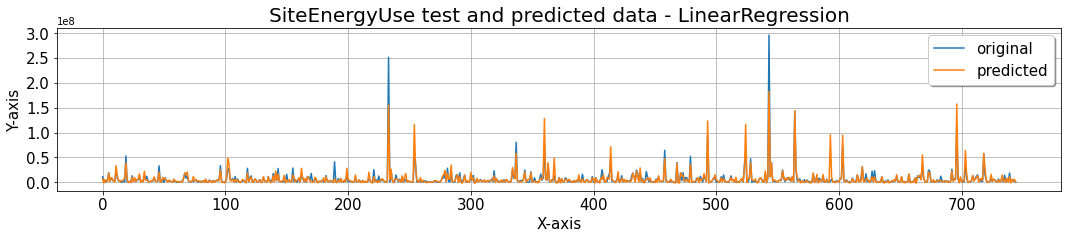

In [205]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

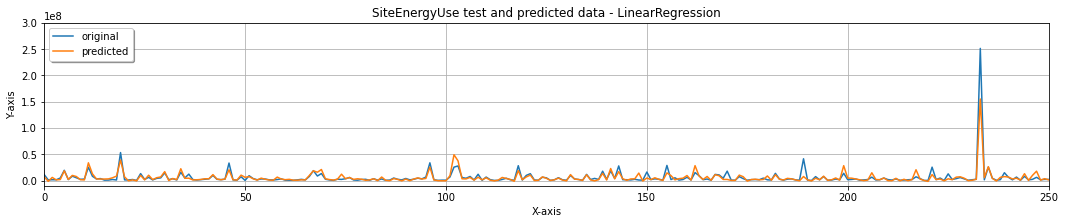

In [209]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(0, 250)
plt.ylim(-0.1e8, 3e8)
plt.show()

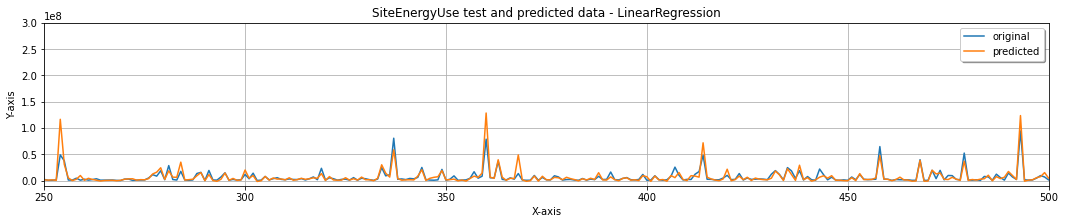

In [210]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(250, 500)
plt.ylim(-0.1e8, 3e8)
plt.show()

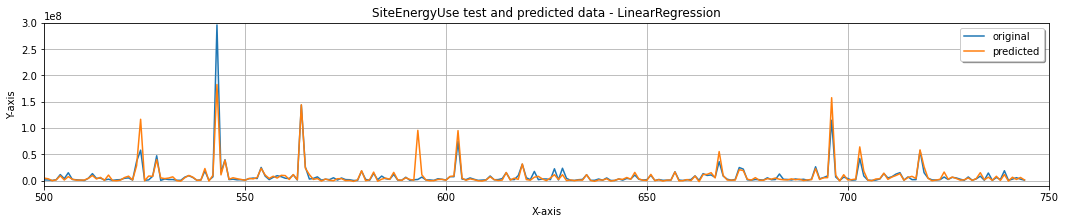

In [211]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(500, 750)
plt.ylim(-0.1e8, 3e8)
plt.show()

### Comparaison avec le modèle RandomForestRegressor sélectionné

In [169]:
# RandomForestRegressor optimisé

rfr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 15,
                            min_samples_split = 2)

rfr.fit(X_train, y_train)

# Définition des prédictions sur jeu de test
rfr_preds = rfr.predict(X_test)

# impression du coefficient de détermination
print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
rfr_preds_train = rfr.predict(X_train)
# impression du coefficient de détermination
print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
print("---------------------")

RandomForestRegressor_r2_score test : 0.9360702737499834
RandomForestRegressor_RMSE test : 4637861.933037552
---------------------
RandomForestRegressor_r2_score train : 0.9498316080637133
RandomForestRegressor_RMSE train : 6210621.396263381
---------------------


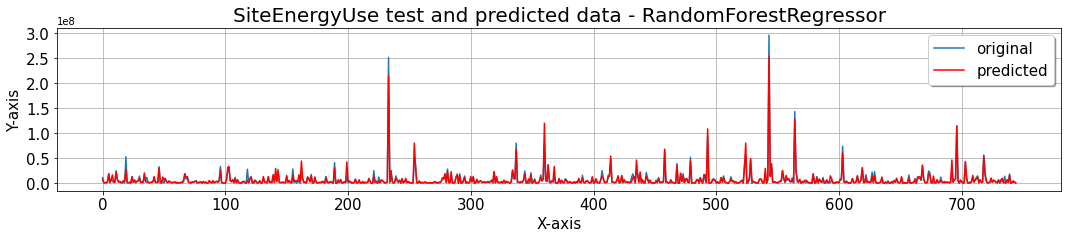

In [212]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

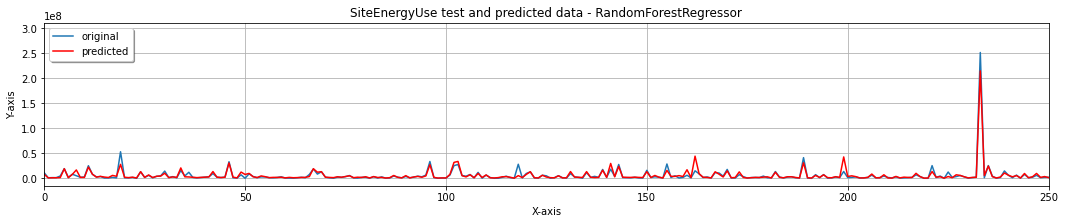

In [213]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(0,250)
plt.show()

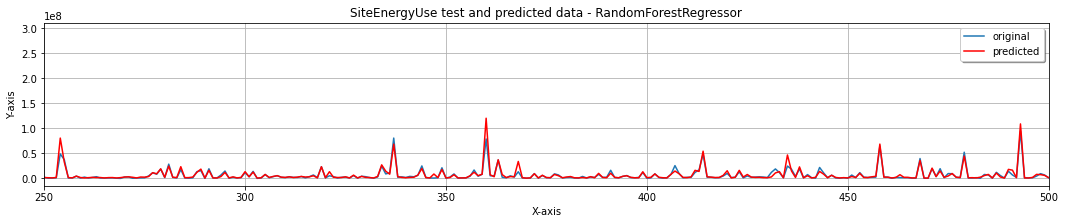

In [214]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(250,500)
plt.show()

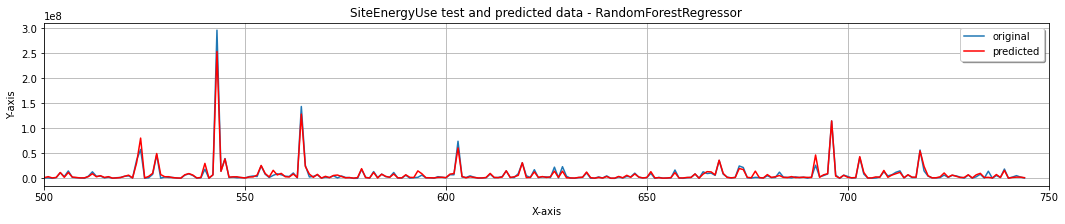

In [215]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim(500,750)
plt.show()

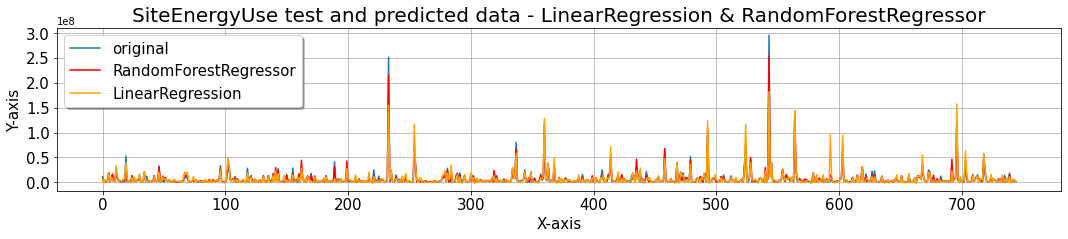

In [217]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="RandomForestRegressor", color='red')
plt.plot(x_ax, y_pred, label="LinearRegression", color='orange')
plt.title("SiteEnergyUse test and predicted data - LinearRegression & RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

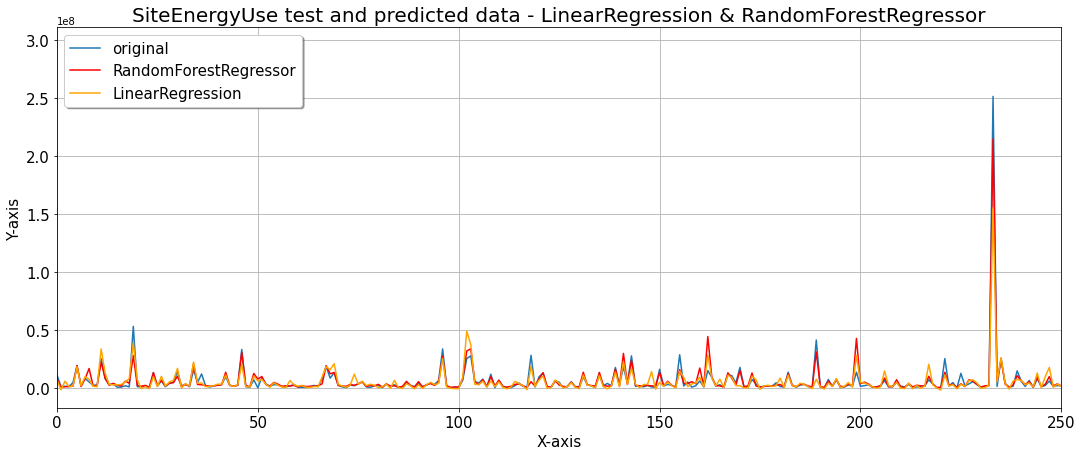

In [219]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,7))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="RandomForestRegressor", color='red')
plt.plot(x_ax, y_pred, label="LinearRegression", color='orange')
plt.title("SiteEnergyUse test and predicted data - LinearRegression & RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(0,250)
plt.show()

### Comparaison #2

In [222]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X4, ye, test_size=0.30)

In [223]:
# Régression linéaire simple
# Sélection des features
X_train = X_train[selfeat_X4]
X_test = X_test[selfeat_X4]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X4) != 0:
    X_train = pd.get_dummies(X_train, columns = selcatfeat_X4, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat_X4, drop_first=True)
    
# Application de la REGRESSION LINEAIRE classique
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Récupération du coefficient de détermination sur le jeu de données test
r2_lr_test = r2_score(y_test, lr.predict(X_test))
# Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
# impression du coefficient de détermination
print("REGRESSION LINEAIRE")
print("r2_lr test :", r2_lr_test)
# impression de la Root Mean Squared Error (RMSE)
print("RMSE_lr test :", RMSE_lr_test)
print('-----------------------')

REGRESSION LINEAIRE
r2_lr test : 0.8135850692861553
RMSE_lr test : 9833049.651039174
-----------------------


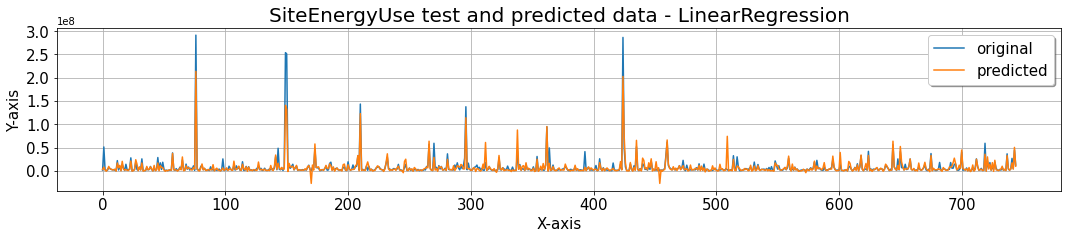

In [224]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

In [225]:
# RandomForestRegressor optimisé

rfr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 15,
                            min_samples_split = 2)

rfr.fit(X_train, y_train)

# Définition des prédictions sur jeu de test
rfr_preds = rfr.predict(X_test)

# impression du coefficient de détermination
print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
rfr_preds_train = rfr.predict(X_train)
# impression du coefficient de détermination
print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
print("---------------------")

RandomForestRegressor_r2_score test : 0.8795580783954379
RandomForestRegressor_RMSE test : 7903814.212556969
---------------------
RandomForestRegressor_r2_score train : 0.9310168432595095
RandomForestRegressor_RMSE train : 6903404.866475822
---------------------


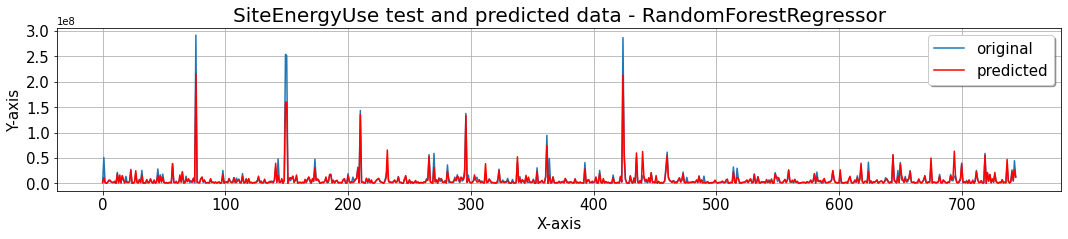

In [226]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

### Comparaison #3

In [234]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X4, ye, test_size=0.30)

In [235]:
# Régression linéaire simple
# Sélection des features
X_train = X_train[selfeat_X4]
X_test = X_test[selfeat_X4]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X4) != 0:
    X_train = pd.get_dummies(X_train, columns = selcatfeat_X4, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat_X4, drop_first=True)
    
# Application de la REGRESSION LINEAIRE classique
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Récupération du coefficient de détermination sur le jeu de données test
r2_lr_test = r2_score(y_test, lr.predict(X_test))
# Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
# impression du coefficient de détermination
print("REGRESSION LINEAIRE")
print("r2_lr test :", r2_lr_test)
# impression de la Root Mean Squared Error (RMSE)
print("RMSE_lr test :", RMSE_lr_test)
print('-----------------------')

REGRESSION LINEAIRE
r2_lr test : 0.7126933804080514
RMSE_lr test : 8055405.9305802025
-----------------------


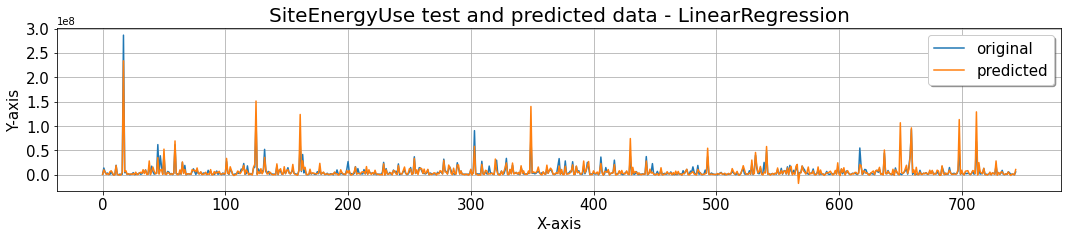

In [236]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

In [237]:
# RandomForestRegressor optimisé

rfr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 15,
                            min_samples_split = 2)

rfr.fit(X_train, y_train)

# Définition des prédictions sur jeu de test
rfr_preds = rfr.predict(X_test)

# impression du coefficient de détermination
print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
rfr_preds_train = rfr.predict(X_train)
# impression du coefficient de détermination
print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
print("---------------------")

RandomForestRegressor_r2_score test : 0.918895619635379
RandomForestRegressor_RMSE test : 4279931.020625947
---------------------
RandomForestRegressor_r2_score train : 0.9327626664247838
RandomForestRegressor_RMSE train : 7406001.2915871935
---------------------


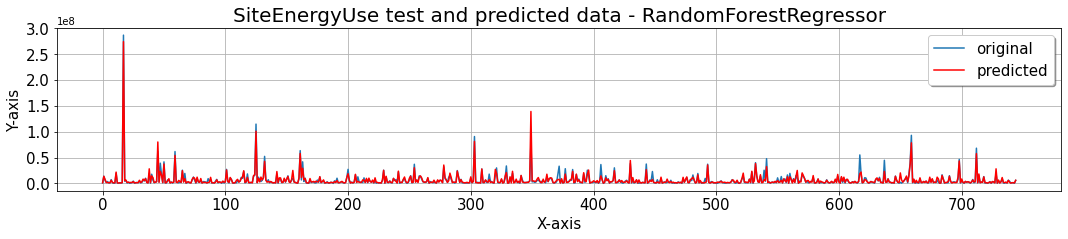

In [238]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

# TotalGHGEmissions

### Sans ENERGYSTARScore (sur data)

In [39]:
# find the most correlated quantitative columns for TotalGHGEmissions:
data_corr = abs(data[['TotalGHGEmissions',
                      'PropertyGFABuilding(s)',
                     'NumberofBuildings',
                     'log10PropertyGFABuilding',
                     'NumberofFloors',
                     'PropertyGFAParking',
                     'prop_steam',
                     'log10PropertyGFAParking',
                     'YearBuilt',
                     'prop_naturalgas',
                     'prop_electricity']].corr()).sort_values(by='TotalGHGEmissions',
                                         ascending=False)[['TotalGHGEmissions']]
data_corr

,TotalGHGEmissions
TotalGHGEmissions,1.000000
PropertyGFABuilding(s),0.598736
NumberofBuildings,0.409112
log10PropertyGFABuilding,0.408267
prop_steam,0.299395
NumberofFloors,0.159659
prop_electricity,0.124896
PropertyGFAParking,0.071652
log10PropertyGFAParking,0.064351
YearBuilt,0.040664


In [47]:
# Création d'une matrice contenant toutes les features quantitatives et catégorielles
# les features catégorielles seront ensuite encodées avec OneHotEncoder
# (Sans ENERGYSTARScore)
selfeat_X1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X1 = ['PrimaryPropertyType', 'Neighborhood']
X1 = data[selfeat_X1]

# Création d'une matrice avec features corrélées à plus de 0.1 et features catégorielles
# on retire les features corrélées entre elles à plus de 0.6
# (NumberofBuildings corrélée à PropertyGFABuilding(s) à 0.73)
# Sans ENERGYSTARScore
selfeat_X2 = ['PrimaryPropertyType', 'Neighborhood', 'NumberofFloors', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam']
selcatfeat_X2 = ['PrimaryPropertyType', 'Neighborhood']
X2 = data[selfeat_X2]

# Création d'une matrice avec features corrélées à plus de 0.4 et features catégorielles
# Sans ENERGYSTARScore
selfeat_X3 = ['PrimaryPropertyType', 'Neighborhood', 'PropertyGFABuilding(s)']

selcatfeat_X3 = ['PrimaryPropertyType', 'Neighborhood']

X3 = data[selfeat_X3]

# Comme X1 sans 'Neighborhood'
selfeat_X4 = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']

selcatfeat_X4 = ['PrimaryPropertyType']

X4 = data[selfeat_X4]

# Comme X2 sans 'Neighborhood'
selfeat_X5 = ['PrimaryPropertyType', 'NumberofFloors', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam']

selcatfeat_X5 = ['PrimaryPropertyType']

X5 = data[selfeat_X5]

# Comme X3 sans 'Neighborhood'
selfeat_X6 = ['PrimaryPropertyType', 'PropertyGFABuilding(s)']

selcatfeat_X6 = ['PrimaryPropertyType']

X6 = data[selfeat_X6]

# Création de l'array 'target' : TotalGHGEmissions
yg = data['TotalGHGEmissions'].values

### Choix des features pour la target "log10GHGEmissions"

In [41]:
# find the most correlated quantitative columns for log10SiteEnergyUse:
data_corr = abs(data[['log10GHGEmissions',
                      'PropertyGFABuilding(s)',
                     'NumberofBuildings',
                     'log10PropertyGFABuilding',
                     'NumberofFloors',
                     'PropertyGFAParking',
                     'prop_steam',
                     'log10PropertyGFAParking',
                     'YearBuilt',
                     'prop_naturalgas',
                     'prop_electricity']].corr()).sort_values(by='log10GHGEmissions',
                                         ascending=False)[['log10GHGEmissions']]
data_corr

,log10GHGEmissions
log10GHGEmissions,1.000000
log10PropertyGFABuilding,0.635378
prop_electricity,0.433813
PropertyGFABuilding(s),0.399535
prop_naturalgas,0.339378
NumberofFloors,0.324239
log10PropertyGFAParking,0.287074
prop_steam,0.285825
PropertyGFAParking,0.270520
YearBuilt,0.129100


In [42]:
# Création d'une matrice contenant toutes les features quantitatives et catégorielles
# les features catégorielles seront ensuite encodées avec OneHotEncoder
# (Sans ENERGYSTARScore)
selfeat_X1_log = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X1 = ['PrimaryPropertyType', 'Neighborhood']
X1_log = data[selfeat_X1_log]

# Création d'une matrice avec features corrélées à plus de 0.1 et features catégorielles
# on retire les features corrélées entre elles à plus de 0.6
# (prop_naturalgas corrélée à prop_electricity à -0.94)
selfeat_X2_log = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam']
selcatfeat_X2 = ['PrimaryPropertyType', 'Neighborhood']
X2_log = data[selfeat_X2_log]

# Création d'une matrice avec features corrélées à plus de 0.4 et features catégorielles
selfeat_X3_log = ['PrimaryPropertyType', 'Neighborhood', 'log10PropertyGFABuilding',
              'prop_electricity']
selcatfeat_X3 = ['PrimaryPropertyType', 'Neighborhood']
X3_log = data[selfeat_X3_log]

# Comme X1 sans 'Neighborhood' (moins corrélée à SiteEnergyUse que 'PrimaryPropertyType')
selfeat_X4_log = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X4 = ['PrimaryPropertyType']
X4_log = data[selfeat_X4_log]

# Comme X2 sans 'Neighborhood'
selfeat_X5_log = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'log10PropertyGFAParking', 'log10PropertyGFABuilding',
              'prop_electricity', 'prop_steam']
selcatfeat_X5 = ['PrimaryPropertyType']
X5_log = data[selfeat_X5_log]

# Comme X3 sans 'Neighborhood'
selfeat_X6_log = ['PrimaryPropertyType', 'log10PropertyGFABuilding', 'prop_electricity']
selcatfeat_X6 = ['PrimaryPropertyType']
X6_log = data[selfeat_X6_log]

# Création de l'array 'target' : TotalGHGEmissions
yg = data['TotalGHGEmissions'].values

In [43]:
# Définition de fonctions pour afficher les Stats de "GHGEmissions": 

def GHGEmissions(df):
    # impression des statistiques de GHGEmissions
    print("GHGEmissions")
    print("moy :",df['TotalGHGEmissions'].mean())
    print("med :",df['TotalGHGEmissions'].median())
    print("var :",df['TotalGHGEmissions'].var())
    print("std :",df['TotalGHGEmissions'].std())

def logGHGEmissions(df):
    # impression des statistiques de log10GHGEmissions
    print("log10GHGEmissions")
    print("moy :",np.log10(df['TotalGHGEmissions']).mean())
    print("med :",np.log10(df['TotalGHGEmissions']).median())
    print("var :",np.log10(df['TotalGHGEmissions']).var())
    print("std :",np.log10(df['TotalGHGEmissions']).std())

### Test des différents dataframes sur régression linéaire classique (+ cross-validation) et target "TotalGHGEmissions"

In [44]:
GHGEmissions(data)

GHGEmissions
moy : 163.80724526782083
med : 46.36
var : 427820.3532364854
std : 654.0797758962475


In [30]:
# Test des dataframe contenant les différentes features quantitatives et catégorielles
# de X1 à X6
LinReg_cv(Xx = X6, 
          selcatfeat = selcatfeat_X6, 
          y = yg, 
          n_splits = 5, 
          n_repeats = 100)

moyenne r2 test = 0.5944457598633374
écart-type r2 test = 0.25245702397413394
moyenne r2 train = 0.7310827126308542
écart-type r2 train = 0.021275452005500753
------------------------------------
moyenne RMSE test = -368.72131001329404
écart-type RMSE test = 85.89626970515383
moyenne RMSE train = -337.40744178699094
écart-type RMSE train = 18.92397164988251


*Conclusion*. Après avoir testé X1 à X6 :

- Meilleurs résultats avec features corrélées à plus de 0.1 et 0.4

- La feature catégorielle "Neighborhood" n'est pas utile

-> On choisira le dataframe X5 pour la suite : features quantitatives corrélées à plus de 0.1 + "PrimaryPropertyType"

### Test des différents dataframes sur régression linéaire classique et target "log10SiteEnergyUse"

In [121]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X, yg, test_size=0.30)

In [129]:
# Régression linéaire sur "log10GHGEmissions"
LinReg_log(selfeat_X4_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.8450429313179263
RMSE_lr test : 219.67668633412777
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log test : 0.8328616052788873
RMSE_lr_log test : 0.2581874995611064
---------------------
REGRESSION LINEAIRE
r2_lr train : 0.877142032724497
RMSE_lr train : 242.17415492984094
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log train : 0.8204397126395969
RMSE_lr_log train : 0.28075798118633705
---------------------


In [128]:
# Régression linéaire sur "TotalGHGEmissions"
LinReg(selfeat_X4, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.5450686933326834
RMSE_lr test : 376.40136090664345
-----------------------
REGRESSION LINEAIRE
r2_lr train : 0.7715096501086608
RMSE_lr train : 330.26310644126454
-----------------------


Conclusion : Sélection du X5_log pour la suite des expériences sur la target "log10SiteEnergyUse"

### Test des dataframe X5 et X5_log sur d'autres algorithmes de Machine Learning

In [186]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X, yg, test_size=0.30)

In [187]:
# Régression linéaire sur "TotalGHGEmissions"
LinReg(selfeat_X5, selcatfeat_X5, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : 0.5383884987086607
RMSE_lr test : 452.3361601288857
-----------------------
REGRESSION LINEAIRE
r2_lr train : 0.6989959062868661
RMSE_lr train : 355.9530443635178
-----------------------


In [188]:
# Régression linéaire sur "log10GHGEmissions"
LinReg_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

REGRESSION LINEAIRE
r2_lr test : -3930.99829724301
RMSE_lr test : 41747.42152940498
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log test : 0.8291494389489372
RMSE_lr_log test : 0.27615844895402003
---------------------
REGRESSION LINEAIRE
r2_lr train : 0.818930866378841
RMSE_lr train : 276.0760435301911
---------------------
REGRESSION LINEAIRE LOG
r2_lr_log train : 0.8153994231477186
RMSE_lr_log train : 0.27795900269161233
---------------------


In [189]:
RidgeReg(selfeat_X5, selcatfeat_X5, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

REGRESSION RIDGE avec validation croisée :
ridge optimal alpha : 599.4842503189409
ridge r2_score test : 0.7829830600493343
ridge RMSE test : 310.1485922230811
---------------------
ridge r2_score train : 0.6587848195586252
ridge RMSE train : 378.9838320825233
---------------------


In [190]:
RidgeReg_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -18, logspacemax = -12, n_alphas = 100, n_splits = 5, n_repeats = 3)

REGRESSION RIDGE avec validation croisée :
ridge optimal alpha : 1e-18
ridge r2_score test : -3930.998297243318
ridge r2_score test log : 0.829149438948937
ridge RMSE test : 41747.42152940662
ridge RMSE test log : 0.27615844895402025
---------------------
ridge r2_score train : 0.8189308663788405
ridge r2_score train log : 0.8153994231477186
ridge RMSE train : 276.07604353019155
ridge RMSE train log : 0.27795900269161233
---------------------


In [191]:
Lasso(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

LASSO avec validation croisée :
LASSO optimal alpha : 5.72236765935022
lasso r2_score test : 0.5884256387400771
lasso RMSE test : 427.1172906164926
---------------------
lasso r2_score train : 0.6975164006839838
lasso RMSE train : 356.82676832113395
---------------------


In [192]:
Lasso_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, n_splits = 5, n_repeats = 3)

LASSO avec validation croisée :
LASSO optimal alpha : 0.00210490414451202
lasso r2_score test : -1118.7748436411503
lasso r2_score test log : 0.8323934825503674
lasso RMSE test : 22278.623277920236
lasso RMSE test log : 0.2735240896921421
---------------------
lasso r2_score train : 0.8492258729759641
lasso r2_score train log: 0.8152108528025584
lasso RMSE train : 251.92421961626894
lasso RMSE train log : 0.27810093465983
---------------------


In [193]:
ElasticNet(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -9, logspacemax = 0, n_alphas = 100, 
           l1_ratio=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 
           n_splits = 5, n_repeats = 3)

ELASTIC NET avec validation croisée :
elastic_net optimal alpha : 0.1
elastic_net optimal l1_ratio : 0.2
elastic net r2_score test : 0.6637168958468493
elastic net RMSE test : 386.0784138564786
---------------------
elastic net r2_score train : 0.6951009622315099
elastic net RMSE train : 358.2486293816851
---------------------


In [195]:
ElasticNet_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
             logspacemin = -5, logspacemax = 5, n_alphas = 100, 
           l1_ratio=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1], 
           n_splits = 5, n_repeats = 3)

ELASTIC NET avec validation croisée :
elastic_net optimal alpha : 0.00210490414451202
elastic_net optimal l1_ratio : 1.0
elastic net r2_score test : -1118.7748436411503
elastic net r2_score test log: 0.8323934825503674
elastic net RMSE test : 22278.623277920236
elastic net RMSE test log : 0.2735240896921421
---------------------
elastic net r2_score train : 0.8492258729759641
elastic net r2_score train log : 0.8152108528025584
elastic net RMSE train : 251.92421961626894
elastic net RMSE train log : 0.27810093465983
---------------------


In [196]:
LinearSVR(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

LINEAR_SVR avec validation croisée :
linearSVR_best_C : 1261856.8830660211
linearSVR_best_max_iter : 1000
Linear_SVR r2_score test : 0.6154381056887869
Linear_SVR RMSE test : 412.8631490197693
---------------------
Linear_SVR r2_score train : 0.4560462476207702
Linear_SVR RMSE train : 478.506122688295
---------------------


In [197]:
LinearSVR_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

LINEAR_SVR avec validation croisée :
linearSVR_best_C : 102353102.1899027
linearSVR_best_max_iter : 1000
Linear_SVR r2_score test : 0.007336277539406688
Linear_SVR r2_score test log : 0.20627948729631773
Linear_SVR RMSE test : 663.321496424863
Linear_SVR RMSE test log : 0.5952287945378889
---------------------
Linear_SVR r2_score train : 0.44628141440364066
Linear_SVR r2_score train log : 0.6458197076565648
Linear_SVR RMSE train : 482.7819905841348
Linear_SVR RMSE train log : 0.3850139043989372
---------------------


In [198]:
SVR(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

SVR avec validation croisée :
best_params : {'C': 8111.308307896872, 'max_iter': 1000}
SVR r2_score test : 0.6920883578757095
SVR RMSE test : 369.43331031136074
---------------------
SVR r2_score train : 0.9827735129209523
SVR RMSE train : 85.15396446849087
---------------------


In [199]:
SVR_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test, 
              logspacemin = 2, logspacemax = 9, n_C = 100, 
          n_iter = [1000], 
          n_splits = 5, n_repeats = 1)

SVR avec validation croisée :
best_params : {'C': 100.0, 'max_iter': 1000}
SVR r2_score test : 0.4600100352545681
SVR r2_score test log : 0.7239799367335242
SVR RMSE test : 489.23310967521127
SVR RMSE test log : 0.35101078104419176
---------------------
SVR r2_score train : 0.5383814351102436
SVR r2_score train log : 0.7563551399130275
SVR RMSE train : 440.8066563144506
SVR RMSE train log : 0.3193322969402555
---------------------


In [200]:
RandomForest(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test)

RandomForestRegressor_r2_score test : 0.7475527276393872
RandomForestRegressor_RMSE test : 334.5094088537198
---------------------
RandomForestRegressor_r2_score train : 0.9844085521854534
RandomForestRegressor_RMSE train : 81.01207075512369
---------------------


In [ ]:
RandomForest_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

In [202]:
GradientBoosting(selfeat_X5, selcatfeat_X4, X_train, X_test, y_train, y_test)

GradientBoostingRegressor_r2_score test : 0.6687870984444565
GradientBoostingRegressor_RMSE test : 383.1568720269517
---------------------
GradientBoostingRegressor_r2_score train : 0.9879106528019417
GradientBoostingRegressor_RMSE train : 71.33586566975144
---------------------


In [203]:
GradientBoosting_log(selfeat_X5_log, selcatfeat_X4, X_train, X_test, y_train, y_test)

GradientBoostingRegressor_r2_score test : 0.6159744617443911
GradientBoostingRegressor_r2_score test log : 0.8625684720953815
GradientBoostingRegressor_RMSE test : 412.5751343730503
GradientBoostingRegressor_RMSE test log : 0.24768135651805687
---------------------
GradientBoostingRegressor_r2_score train : 0.9442569534271863
GradientBoostingRegressor_r2_score train log : 0.8817861643172425
GradientBoostingRegressor_RMSE train : 153.17992800617074
GradientBoostingRegressor_RMSE train log : 0.2224325662530772
---------------------


Conclusion : après plusieurs essais, les meilleurs résultats (RMSE et r2) sont obtenus avec le RandomForestRegressor sur la target "non log"

### Optimisation du modèle choisi : GridSearchCV sur RandomForestRegressor

In [46]:
RFR_gs_cv(Xx = X5,
          selcatfeat = selcatfeat_X5,
          y = yg,
          n_splits = 5,
          n_repeats_1 = 3,
          n_repeats_2 = 5,
          n_estimators = [100, 200, 500],
          max_depth = [10, 20, 30],
         min_samples_split = [2, 3])

RandomForestRegression avec validation croisée :
best_params : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
moyenne r2 test = 0.8531879189052041
écart-type r2 test = 0.16501681467962606
moyenne r2 train = 0.973183391231936
écart-type r2 train = 0.007955769780698119
------------------------------------
moyenne RMSE test = -214.59292131509287
écart-type RMSE test = 133.2584380326009
moyenne RMSE train = -105.6001526383432
écart-type RMSE train = 15.849442231722888
------------------------------------
moyenne fit time = 0.36821880340576174
moyenne score time = 0.011296567916870117
    fit_time  score_time   test_r2  train_r2  \
0   0.409903    0.010971  0.684013  0.986014   
1   0.403950    0.011936  0.809854  0.974202   
2   0.411896    0.014960  0.967141  0.960841   
3   0.396937    0.012998  0.960525  0.971187   
4   0.419877    0.011966  0.951146  0.976650   
5   0.411888    0.013003  0.806421  0.976088   
6   0.415855    0.012000  0.975628  0.956645   
7   0.408904 

Conclusion : Après plusieurs tests, on choisira le modèle RandomForestRegressor avec
- n_estimators = 100
- max_depth = 10
- min_samples_split = 2

### Visualisation : comparaison y_test et rfr_preds pour LinearRegression et RandomForestRegressor

### Comparaison #1

In [48]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X5, yg, test_size=0.30)

In [49]:
# Régression linéaire simple
# Sélection des features
X_train = X_train[selfeat_X5]
X_test = X_test[selfeat_X5]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X5) != 0:
    X_train = pd.get_dummies(X_train, columns = selcatfeat_X5, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat_X5, drop_first=True)
    
# Application de la REGRESSION LINEAIRE classique
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Récupération du coefficient de détermination sur le jeu de données test
r2_lr_test = r2_score(y_test, lr.predict(X_test))
# Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
# impression du coefficient de détermination
print("REGRESSION LINEAIRE")
print("r2_lr test :", r2_lr_test)
# impression de la Root Mean Squared Error (RMSE)
print("RMSE_lr test :", RMSE_lr_test)
print('-----------------------')

REGRESSION LINEAIRE
r2_lr test : 0.7139177423771734
RMSE_lr test : 377.58128400720796
-----------------------


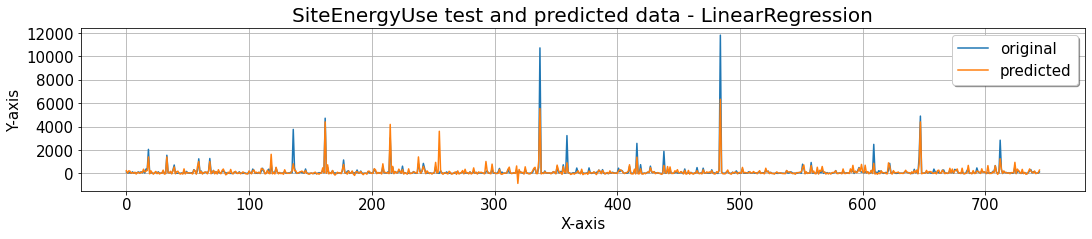

In [50]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

In [51]:
# RandomForestRegressor optimisé

rfr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 10,
                            min_samples_split = 2)

rfr.fit(X_train, y_train)

# Définition des prédictions sur jeu de test
rfr_preds = rfr.predict(X_test)

# impression du coefficient de détermination
print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
rfr_preds_train = rfr.predict(X_train)
# impression du coefficient de détermination
print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
print("---------------------")

RandomForestRegressor_r2_score test : 0.9547170597101139
RandomForestRegressor_RMSE test : 150.22157328010562
---------------------
RandomForestRegressor_r2_score train : 0.9643009797224564
RandomForestRegressor_RMSE train : 119.07757987763586
---------------------


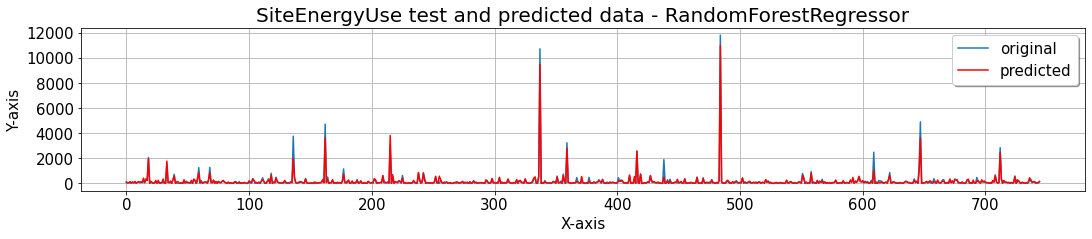

In [52]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

### Comparaison #2

In [53]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X5, yg, test_size=0.30)

In [54]:
# Régression linéaire simple
# Sélection des features
X_train = X_train[selfeat_X5]
X_test = X_test[selfeat_X5]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X5) != 0:
    X_train = pd.get_dummies(X_train, columns = selcatfeat_X5, drop_first=True)
    X_test = pd.get_dummies(X_test, columns = selcatfeat_X5, drop_first=True)
    
# Application de la REGRESSION LINEAIRE classique
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Récupération du coefficient de détermination sur le jeu de données test
r2_lr_test = r2_score(y_test, lr.predict(X_test))
# Récupération de la root erreur quadratique moyenne (RMSE) sur le jeu de données test
RMSE_lr_test = math.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
# impression du coefficient de détermination
print("REGRESSION LINEAIRE")
print("r2_lr test :", r2_lr_test)
# impression de la Root Mean Squared Error (RMSE)
print("RMSE_lr test :", RMSE_lr_test)
print('-----------------------')

REGRESSION LINEAIRE
r2_lr test : 0.6820755485055211
RMSE_lr test : 324.9848450865432
-----------------------


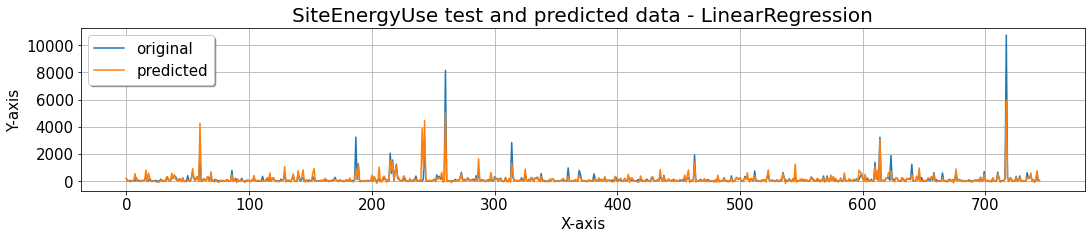

In [55]:
# Visualisation de y_pred en par rapport à y_test pour la régression linéaire ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("SiteEnergyUse test and predicted data - LinearRegression", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

In [56]:
# RandomForestRegressor optimisé

rfr = RandomForestRegressor(n_estimators = 100,
                            max_depth = 10,
                            min_samples_split = 2)

rfr.fit(X_train, y_train)

# Définition des prédictions sur jeu de test
rfr_preds = rfr.predict(X_test)

# impression du coefficient de détermination
print("RandomForestRegressor_r2_score test :", r2_score(y_test, rfr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, rfr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
rfr_preds_train = rfr.predict(X_train)
# impression du coefficient de détermination
print("RandomForestRegressor_r2_score train :", r2_score(y_train, rfr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("RandomForestRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, rfr_preds_train)))
print("---------------------")

RandomForestRegressor_r2_score test : 0.9379361291827256
RandomForestRegressor_RMSE test : 143.58880228346734
---------------------
RandomForestRegressor_r2_score train : 0.9720063272886814
RandomForestRegressor_RMSE train : 114.52807696382682
---------------------


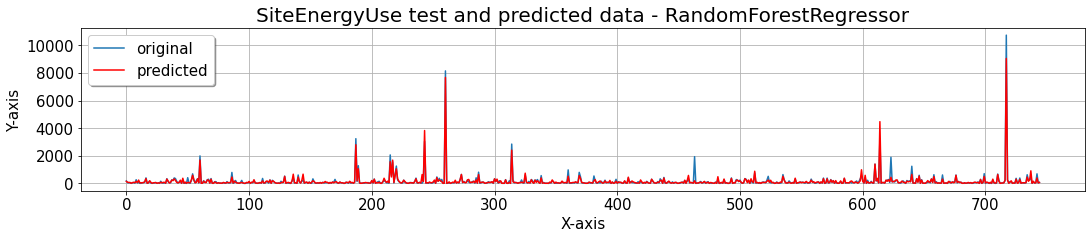

In [57]:
# Visualisation de y_pred en par rapport à y_test pour le RandomForestRegressor ci-dessus
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, rfr_preds, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - RandomForestRegressor", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

### TotalGHGEmissions avec ou sans ENERGYSTARScore (sur data_ESS)

In [58]:
# find the most correlated columns for TotalGHGEmissions:
data_ESS_corr = abs(data_ESS[['TotalGHGEmissions',
                              'PropertyGFABuilding(s)',
                              'NumberofBuildings',
                              'log10PropertyGFABuilding',
                              'NumberofFloors',
                              'PropertyGFAParking',
                              'prop_steam',
                              'log10PropertyGFAParking',
                              'YearBuilt',
                              'prop_naturalgas',
                              'prop_electricity',
                             'ENERGYSTARScore']].corr()).sort_values(by='TotalGHGEmissions',
                                               ascending=False)[['TotalGHGEmissions']]
data_ESS_corr

,TotalGHGEmissions
TotalGHGEmissions,1.000000
PropertyGFABuilding(s),0.530785
NumberofBuildings,0.470997
log10PropertyGFABuilding,0.377880
prop_steam,0.321645
NumberofFloors,0.177772
prop_electricity,0.129619
ENERGYSTARScore,0.093791
PropertyGFAParking,0.076621
log10PropertyGFAParking,0.068514


In [131]:
# Création d'une matrice contenant toutes les features quantitatives et seulement 1 feature catégorielle
# la feature catégorielle est ensuite encodée avec OneHotEncoder
# Avec ENERGYSTARScore
selfeat_X1_ESS = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas', 'ENERGYSTARScore']
selcatfeat_X1_ESS = ['PrimaryPropertyType']
X1_ESS = data_ESS[selfeat_X1_ESS]

# Création d'une matrice contenant toutes les features quantitatives et seulement 1 feature catégorielle
# la feature catégorielle est ensuite encodée avec OneHotEncoder
# Sans ENERGYSTARScore
selfeat_X1 = ['PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
              'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'prop_naturalgas']
selcatfeat_X1 = ['PrimaryPropertyType']
X1 = data_ESS[selfeat_X1]

# Création d'une matrice avec features corrélées à plus de 0.1 et 1 feature catégorielle
# on retire les features corrélées entre elles à plus de 0.6
# (NumberofFloors corrélée à PropertyGFABuilding(s) à 0.69)
# Avec ENERGYSTARScore
selfeat_X2_ESS = ['PrimaryPropertyType', 'NumberofBuildings', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam', 'ENERGYSTARScore']
selcatfeat_X2_ESS = ['PrimaryPropertyType']
X2_ESS = data_ESS[selfeat_X2_ESS]

# Création d'une matrice avec features corrélées à plus de 0.1 et 1 feature catégorielle
# on retire les features corrélées entre elles à plus de 0.6
# (NumberofFloors corrélée à PropertyGFABuilding(s) à 0.69)
# Sans ENERGYSTARScore
selfeat_X2 = ['PrimaryPropertyType', 'NumberofBuildings', 'PropertyGFABuilding(s)',
              'prop_electricity', 'prop_steam']
selcatfeat_X2 = ['PrimaryPropertyType']
X2 = data_ESS[selfeat_X2]

# Création de l'array 'target' : TotalGHGEmissions
yg = data_ESS['TotalGHGEmissions'].values

### Tests des modèles les plus efficaces GradientBoosting et RandomForest sur les dataframe X1, X1_ESS, X2 et X2_ESS

In [132]:
# Création d'un dataframe contenant toutes les features et sans les target
X = data_ESS[['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 
              'NumberofBuildings', 'NumberofFloors', 'log10PropertyGFAParking', 
              'PropertyGFAParking', 'log10PropertyGFABuilding', 'PropertyGFABuilding(s)', 
              'prop_electricity', 'prop_steam', 'prop_naturalgas', 'ENERGYSTARScore']]

In [88]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
X_train, X_test, y_train, y_test = train_test_split(X, yg, test_size=0.30)

In [101]:
RandomForest(selfeat_X1_ESS, selcatfeat_X1, X_train, X_test, y_train, y_test)

RandomForestRegressor_r2_score test : 0.8595449451067312
RandomForestRegressor_RMSE test : 318.02959346736634
---------------------
RandomForestRegressor_r2_score train : 0.9685664059290071
RandomForestRegressor_RMSE train : 97.50658024974669
---------------------


In [113]:
GradientBoosting(selfeat_X1_ESS, selcatfeat_X1, X_train, X_test, y_train, y_test)

GradientBoostingRegressor_r2_score test : 0.9621605305919606
GradientBoostingRegressor_RMSE test : 165.0712219449573
---------------------
GradientBoostingRegressor_r2_score train : 0.9939729227986445
GradientBoostingRegressor_RMSE train : 42.6963040107584
---------------------


-> On choisit les features X2 et X2_ESS pour des tests avec GridSearchCV sur GradientBoostingRegressor

In [123]:
# Création de la fonction GradientBoosting avec GridSearchCV puis cross_validation
# pour avoir un score moyen avec une bonne accuracy
def GBR_gs_cv(Xx, selcatfeat, y, n_estimators, max_depth,
              min_samples_split, learning_rate, n_splits, n_repeats_1, n_repeats_2):
 
    """[summary]

    Args:
        selfeat (liste) : liste de toutes les features sélectionnées (catégorielles et quantitatives)
        selcatfeat (liste) : liste des features catégorielles sélectionnées
        X_train, X_test, y_train, y_test : jeux de features et arrays de target générés par train_test_split 
                                            avant d'appeler la fonction
        logspacemin, logspacemax, n_C (int) : définition de l'espace de recherche du meilleur C
        n_splits (int) : nombre de folds pour la cross-validation
        n_repeats (int) : nombre de répétitions de cross-validations
        learning_rate : vitesse de descente de gradient
    """
    
    # Transform features using one-hot-encoding; 
    # Drop the first dummy feature
    if len(selcatfeat) != 0:
        X = pd.get_dummies(Xx, columns = selcatfeat, drop_first=True)
    else:
        X = Xx
    
    cv_1 = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats_1)

    param_grid = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "learning_rate": learning_rate
    }

    gbr = ensemble.GradientBoostingRegressor()
    
    gs_gbr = GridSearchCV(estimator = gbr,
                          param_grid = param_grid,
                          cv = cv_1)

    gs_gbr.fit(X, y)
    
    # Affichage des meilleurs paramètres
    print("Gradient Boosting Regression avec validation croisée :")
    print("best_params :", gs_gbr.best_params_)
    gbr_best_n_estimators = list(gs_gbr.best_params_.values())[3]
    gbr_best_max_depth = list(gs_gbr.best_params_.values())[1]
    gbr_best_min_samples_split = list(gs_gbr.best_params_.values())[2]
    gbr_best_learning_rate = list(gs_gbr.best_params_.values())[0]
    
    cv_2 = RepeatedKFold(n_splits = n_splits, n_repeats = n_repeats_2)
    
    gbr_opt = ensemble.GradientBoostingRegressor(n_estimators = gbr_best_n_estimators,
                                                 max_depth = gbr_best_max_depth,
                                                 min_samples_split = gbr_best_min_samples_split,
                                                 learning_rate = gbr_best_learning_rate)

    gbr_opt_scores = cross_validate(gbr_opt, X, y, cv = cv_2,
                                    scoring = ('r2', 'neg_root_mean_squared_error'),
                                    return_train_score = True)

    cv_results = pd.DataFrame(gbr_opt_scores)

    print('moyenne r2 test =', cv_results['test_r2'].mean())
    print('écart-type r2 test =', cv_results['test_r2'].std())
    print('moyenne r2 train =', cv_results['train_r2'].mean())
    print('écart-type r2 train =', cv_results['train_r2'].std())

    print('------------------------------------')

    print('moyenne RMSE test =', cv_results['test_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE test =', cv_results['test_neg_root_mean_squared_error'].std())
    print('moyenne RMSE train =', cv_results['train_neg_root_mean_squared_error'].mean())
    print('écart-type RMSE train =', cv_results['train_neg_root_mean_squared_error'].std())
    print('------------------------------------')

    print('moyenne fit time =', cv_results['fit_time'].mean())
    print('moyenne score time =', cv_results['score_time'].mean())
    
    print(cv_results)

In [128]:
GBR_gs_cv(Xx = X2_ESS, selcatfeat = selcatfeat_X2, y = yg,
          n_estimators = [200, 300], 
          max_depth = [3, 4, 5],
          min_samples_split = [2, 3], 
          learning_rate = [0.1, 0.05], 
          n_splits = 5, 
          n_repeats_1 = 5, 
          n_repeats_2 = 5)

Gradient Boosting Regression avec validation croisée :
best_params : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
moyenne r2 test = 0.9302676678498903
écart-type r2 test = 0.058712925078052584
moyenne r2 train = 0.9983117568497606
écart-type r2 train = 0.000345117976159387
------------------------------------
moyenne RMSE test = -141.80406495527507
écart-type RMSE test = 71.99854827367552
moyenne RMSE train = -26.447693624672723
écart-type RMSE train = 0.7953275906037456
------------------------------------
moyenne fit time = 0.3754018402099609
moyenne score time = 0.0029537105560302735
    fit_time  score_time   test_r2  train_r2  \
0   0.393456    0.001995  0.961949  0.998529   
1   0.377987    0.002992  0.787671  0.998745   
2   0.379025    0.002994  0.973487  0.997624   
3   0.429439    0.003989  0.873062  0.998670   
4   0.398457    0.002991  0.926708  0.997967   
5   0.418849    0.002992  0.851758  0.998542   
6   0.400124    0.002991  0.966

Conclusion. On choisit comme hyperparamètres :
- n_estimators = 300
- max_depth = 4
- min_sample_split = 2
- learning_rate = 0.1

### Visualisation : comparaison y_test et rfr_preds pour GBR optimisé sur X2 et X2_ESS

### Comparaison #1

In [135]:
# Création des jeux de données d'entrainement et de test (jeu de test = 30%)
# à partir de X (car contient toutes les features)
X_train, X_test, y_train, y_test = train_test_split(X, yg, test_size=0.30)

In [136]:
# Sélection des features sans ENERGYSTARScore
X_train1 = X_train[selfeat_X2]
X_test1 = X_test[selfeat_X2]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X2) != 0:
    X_train1 = pd.get_dummies(X_train1, columns = selcatfeat_X2, drop_first=True)
    X_test1 = pd.get_dummies(X_test1, columns = selcatfeat_X2, drop_first=True)
    
# GradientBoostingRegressor optimisé

gbr = ensemble.GradientBoostingRegressor(n_estimators = 300,
                                         max_depth = 4,
                                         min_samples_split = 2,
                                        learning_rate = 0.1)

gbr.fit(X_train1, y_train)

# Définition des prédictions sur jeu de test
gbr_preds = gbr.predict(X_test1)

# impression du coefficient de détermination
print("GradientBoostingRegressor_r2_score test :", r2_score(y_test, gbr_preds))
# impression de la Root Mean Squared Error (RMSE)
print("GradientBoostingRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, gbr_preds)))
print("---------------------")

# Définition des prédictions sur jeu de train
gbr_preds_train = gbr.predict(X_train1)
# impression du coefficient de détermination
print("GradientBoostingRegressor_r2_score train :", r2_score(y_train, gbr_preds_train))
# impression de la Root Mean Squared Error (RMSE)
print("GradientBoostingRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, gbr_preds_train)))
print("---------------------")

GradientBoostingRegressor_r2_score test : 0.9579663657083907
GradientBoostingRegressor_RMSE test : 167.25323052036993
---------------------
GradientBoostingRegressor_r2_score train : 0.9986315834456333
GradientBoostingRegressor_RMSE train : 21.130452455999944
---------------------


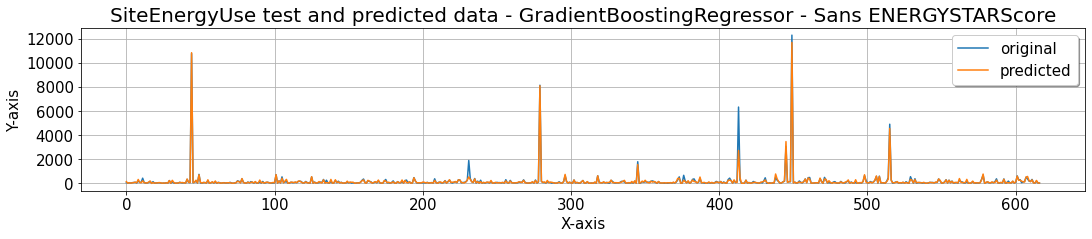

In [137]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds, label="predicted")
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Sans ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

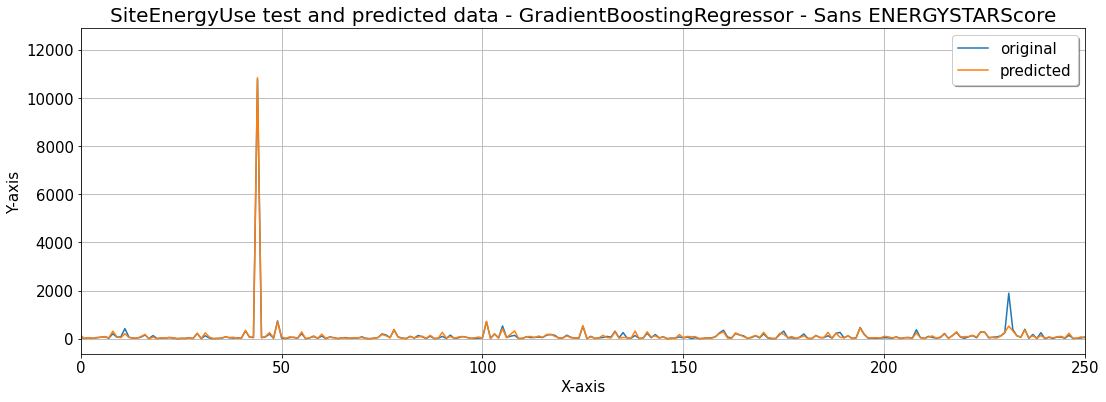

In [139]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds, label="predicted")
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Sans ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(0, 250)
plt.show()

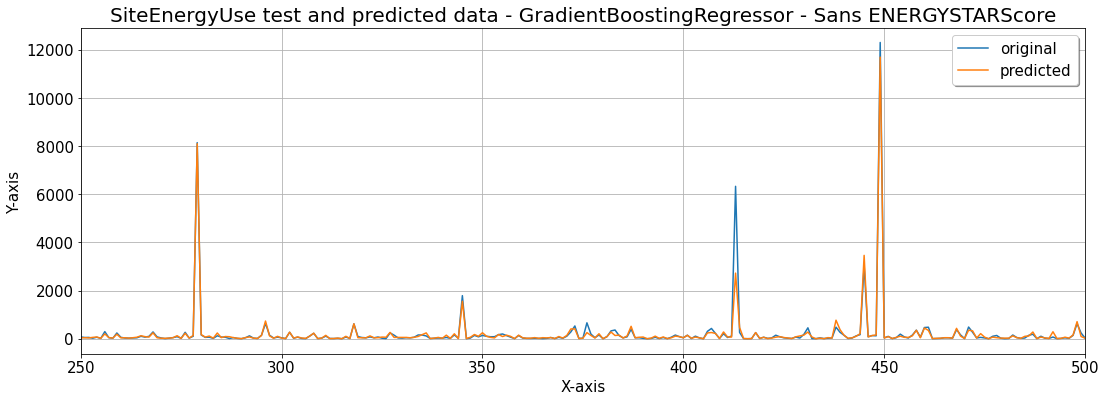

In [140]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds, label="predicted")
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Sans ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(250, 500)
plt.show()

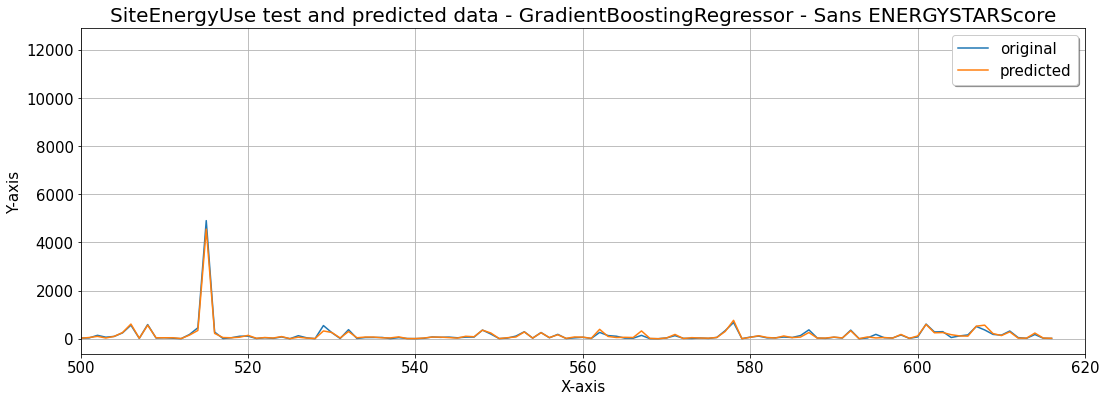

In [141]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds, label="predicted")
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Sans ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(500, 620)
plt.show()

In [142]:
# Sélection des features avec ENERGYSTARScore
X_train2 = X_train[selfeat_X2_ESS]
X_test2 = X_test[selfeat_X2_ESS]
    
# Transform features using one-hot-encoding; 
# Drop the first dummy feature
if len(selcatfeat_X2) != 0:
    X_train2 = pd.get_dummies(X_train2, columns = selcatfeat_X2, drop_first=True)
    X_test2 = pd.get_dummies(X_test2, columns = selcatfeat_X2, drop_first=True)
    
# GradientBoostingRegressor optimisé

gbr = ensemble.GradientBoostingRegressor(n_estimators = 100,
                                         max_depth = 10,
                                         min_samples_split = 2,
                                        learning_rate = 0.05)

gbr.fit(X_train2, y_train)

# Définition des prédictions sur jeu de test
gbr_preds2 = gbr.predict(X_test2)

# impression du coefficient de détermination
print("GradientBoostingRegressor_r2_score test :", r2_score(y_test, gbr_preds2))
# impression de la Root Mean Squared Error (RMSE)
print("GradientBoostingRegressor_RMSE test :", math.sqrt(mean_squared_error(y_test, gbr_preds2)))
print("---------------------")

# Définition des prédictions sur jeu de train
gbr_preds_train2 = gbr.predict(X_train2)
# impression du coefficient de détermination
print("GradientBoostingRegressor_r2_score train :", r2_score(y_train, gbr_preds_train2))
# impression de la Root Mean Squared Error (RMSE)
print("GradientBoostingRegressor_RMSE train :", math.sqrt(mean_squared_error(y_train, gbr_preds_train2)))
print("---------------------")

GradientBoostingRegressor_r2_score test : 0.9519088087402695
GradientBoostingRegressor_RMSE test : 178.89937025786062
---------------------
GradientBoostingRegressor_r2_score train : 0.9997656114266351
GradientBoostingRegressor_RMSE train : 8.745161911781068
---------------------


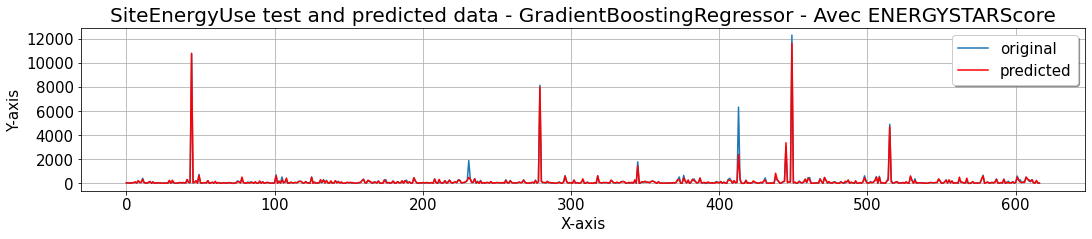

In [143]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,3))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds2, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Avec ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.show()

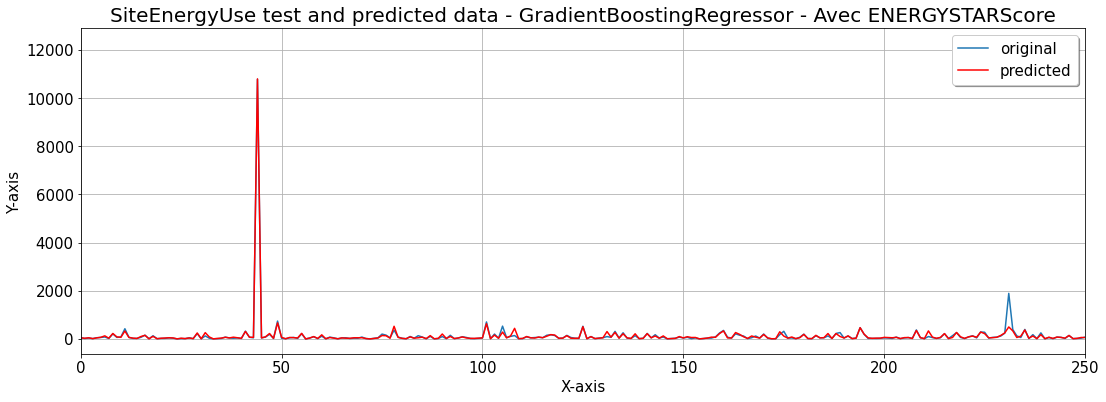

In [144]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds2, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Avec ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(0, 250)
plt.show()

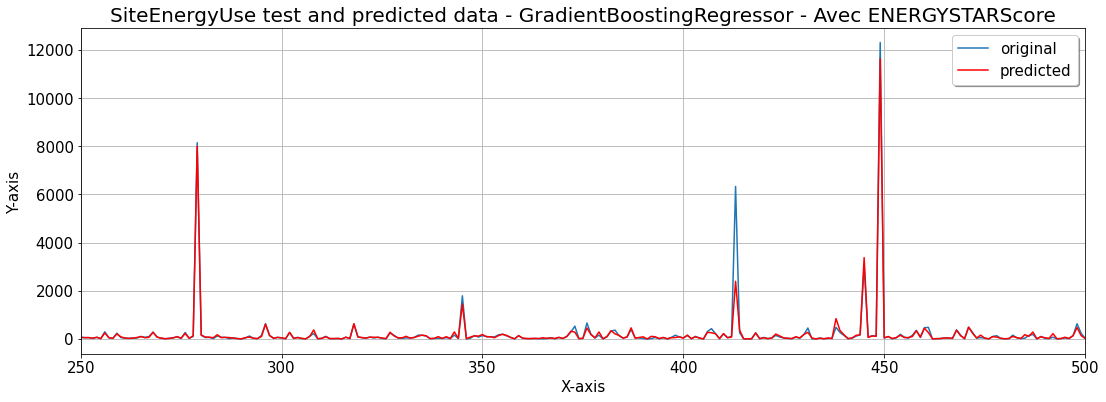

In [145]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds2, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Avec ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(250, 500)
plt.show()

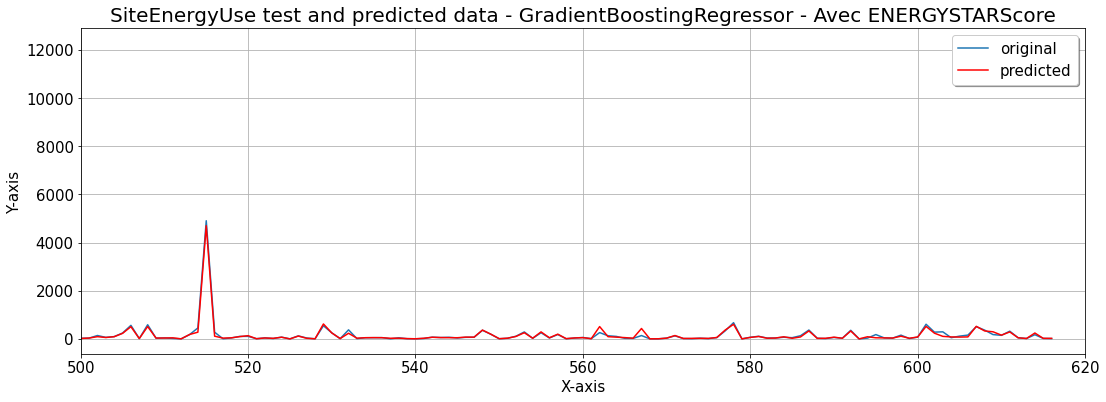

In [146]:
# Visualisation de y_pred en par rapport à y_test pour le GBR ci-dessus sans ENERGYSTARScore
x_ax = range(len(y_test))
fig = plt.figure(figsize=(18,6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, gbr_preds2, label="predicted", color='red')
plt.title("SiteEnergyUse test and predicted data - GradientBoostingRegressor - Avec ENERGYSTARScore", fontsize=20)
plt.xlabel('X-axis', fontsize=15)
plt.ylabel('Y-axis', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
plt.grid(True)
plt.xlim(500, 620)
plt.show()

Conclusion : l'utilisation de l'ENERGYSTARScore pour la prédiction de TotalGHGEmissions ne présente pas d'intérêt particulier